In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import optuna
from sklearn.metrics import f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
import torch
import torch_geometric.transforms as T
from torch_geometric.data import Data
from torch_geometric.loader import NeighborSampler
from torch_geometric.datasets import Planetoid, WikipediaNetwork, Actor, WebKB

import os
import sys

file_dir = os.path.dirname('../')
sys.path.append(file_dir)

from modules.model import Net
from modules.sampling import SamplerContextMatrix, SamplerRandomWalk, SamplerFactorization, SamplerAPP

/data/home/pandreeva/.conda/envs/py377_cpu/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
!nvidia-smi


Thu Jan 12 13:48:19 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 418.126.02   Driver Version: 418.126.02   CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  On   | 00000000:8A:00.0 Off |                    0 |
| N/A   38C    P0    57W / 300W |   8486MiB / 32480MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [3]:
synthetic = True
benchmark_data_dir = "../data_benchmark/"
help_data = "../data_help/"

In [4]:
if synthetic:
    datasets_names=[]
    for l_a_trgt in [0.1,0.5,0.9]:
                for f_a_trgt in [0.1,0.5,0.9]:
                    for cl_trgt in [0.01,0.1,0.2,0.3,0.5]:
                        for asp_trgt in [2,3,4,5,6,7]:
                            for a_deg_trgt in [2,5,10,15,20,25,30,35,40]:
                                datasets_names.append((l_a_trgt,f_a_trgt,cl_trgt,asp_trgt,a_deg_trgt))
    datasets_names_new = []
    for (l,f,cl,asp,ad) in datasets_names:
            name =  "".join(list(map(lambda x:str(x),  [l,f,cl,asp,ad])))
            if os.path.exists('../data_benchmark/graph_'+str(name)+'_attr.npy'):
                datasets_names_new.append((l,f,cl,asp,ad))
    datasets_names = datasets_names_new

    def data_load(name):
        x = torch.tensor(np.load(f'{benchmark_data_dir}/graph_'+str(name)+'_attr.npy'),dtype=torch.float)
        edge_list = torch.tensor(np.load(f'{benchmark_data_dir}/graph_'+str(name)+'_edgelist.npy')).t()
        y =  torch.tensor(np.load(f'{benchmark_data_dir}/graph_'+str(name)+'_labels.npy'))
        data=Data(x=x,edge_index=edge_list,y=y)
        indices=list(range(len(data.x)))

        train_indices = torch.tensor(indices[:int(0.7*len(indices)+1)])
        val_indices = torch.tensor(indices[int(0.7*len(indices)+1):int(0.8*len(indices)+1)])
        test_indices = torch.tensor(indices[int(0.8*len(indices)+1):])
        train_mask = torch.tensor([False]*len(indices))
        test_mask = torch.tensor([False]*len(indices))
        val_mask = torch.tensor([False]*len(indices))
        train_mask[train_indices] =True
        test_mask[test_indices]=True
        val_mask[val_indices]=True
        return data, train_indices,val_indices,test_indices,train_mask,val_mask,test_mask
else:
    datasets_names = ['Cornell','Texas','Wisconsin','Actor','Pubmed','squirrel']

    def data_load(name):
        if name == 'Cora' or name == 'Citeseer' or name == 'Pubmed':
            data = Planetoid(root='/tmp/'+str(name), name=name,transform=T.NormalizeFeatures())[0]
        elif name == 'Actor':
            data = Actor(root='/tmp/actor',transform=T.NormalizeFeatures())[0]
        elif name == "Cornell" or name=="Texas" or name=="Wisconsin":
            data = WebKB(root='/tmp/'+str(name),name=name,transform=T.NormalizeFeatures())[0]
        elif name == 'squirrel' or name=='chameleon':
            data = WikipediaNetwork(root='/tmp/'+str(name), name=name,transform=T.NormalizeFeatures())[0]

        indices=list(range(len(data.x)))

        train_indices = torch.tensor(indices[:int(0.7*len(indices)+1)])
        val_indices = torch.tensor(indices[int(0.7*len(indices)+1):int(0.8*len(indices)+1)])
        test_indices = torch.tensor(indices[int(0.8*len(indices)+1):])
        train_mask = torch.tensor([False]*len(indices))
        test_mask = torch.tensor([False]*len(indices))
        val_mask = torch.tensor([False]*len(indices))
        train_mask[train_indices] =True
        test_mask[test_indices]=True
        val_mask[val_indices]=True
        return data, train_indices,val_indices,test_indices,train_mask,val_mask,test_mask

In [5]:
#loss functions

VERSE_PPR =  {"Name": "VERSE_PPR","C": "PPR","num_negative_samples":[1, 6, 11, 16, 21],"loss var": "Context Matrix","flag_tosave":False,"alpha": [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9],"Sampler" :SamplerContextMatrix,"lmbda": [0.0,1.0]}
VERSE_Adj =  {"Name": "VERSE_Adj","C": "Adj","num_negative_samples":[1, 6, 11, 16, 21],"loss var": "Context Matrix","flag_tosave":False,"Sampler" :SamplerContextMatrix,"lmbda": [0.0,1.0]}

VERSE_SR =  {"Name": "VERSE_SimRank","C": "SR","num_negative_samples":[1, 6, 11, 16, 21],"loss var": "Context Matrix","flag_tosave":False,"Sampler":SamplerContextMatrix,"lmbda": [0.0,1.0]}
DeepWalk = {"Name": "DeepWalk","walk_length":[5, 10, 15, 20],"walks_per_node":[5, 10, 15, 20],"num_negative_samples":[1,6, 11, 16, 21],"context_size" : [5, 10, 15, 20],"p":1,"q":1,"loss var": "Random Walks","flag_tosave":False,"Sampler" : SamplerRandomWalk } #Проблемы с памятью после того, как увеличила количество тренировочных данных
Node2Vec = {"Name": "Node2Vec","walk_length":[5, 10, 15, 20],"walks_per_node":[5, 10, 15, 20],"num_negative_samples":[1,6, 11, 16, 21],"context_size" : [5, 10, 15, 20],"p": [0.25, 0.50, 1, 2, 4] ,"q":[0.25, 0.50, 1, 2, 4], "loss var": "Random Walks","flag_tosave":False,"Sampler": SamplerRandomWalk}#то же самое
APP ={"Name": "APP","C": "PPR","num_negative_samples":[1, 6, 11, 16, 21],"loss var": "Context Matrix","flag_tosave":True,"alpha": [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9],"Sampler" :SamplerAPP}
HOPE_Katz = {"Name": "HOPE_Katz","C":"Katz","loss var": "Factorization","flag_tosave":True,"betta": [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9],"Sampler" :SamplerFactorization,"lmbda": [0.0,1.0]} #проверить

HOPE_RPR = {"Name": "HOPE_RPR","C":"RPR","loss var": "Factorization","flag_tosave":True,"alpha": [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9],"Sampler" :SamplerFactorization,"lmbda": [0.0,1.0]} #проверить
HOPE_CN = {"Name": "HOPE_CommonNeighbors", "C":"CN","loss var": "Factorization","flag_tosave":False,"Sampler" :SamplerFactorization,"lmbda": [0.0,1.0]}
HOPE_AA = {"Name": "HOPE_AdamicAdar","C":"AA","loss var": "Factorization","flag_tosave":True,"Sampler" :SamplerFactorization,"lmbda": [0.0,1.0]}

LapEigen = {"Name": "LaplacianEigenMaps", "C":"Adj","loss var": "Laplacian EigenMaps","flag_tosave":True,"Sampler" :SamplerFactorization,"lmbda": [0.0,1.0]}
LINE = {"Name": "LINE","C": "Adj","num_negative_samples":[1, 6, 11, 16, 21],"loss var": "Context Matrix","flag_tosave":False,"Sampler" :SamplerContextMatrix,"lmbda": [0.0,1.0]}
GraphFactorization = {"Name": "Graph Factorization","C":"Adj","loss var": "Factorization","flag_tosave":False,"Sampler" :SamplerFactorization,"lmbda": [0.0,1.0]}

Force2Vec = {"Name": "Force2Vec","C": "Adj","num_negative_samples":[1, 6, 11, 16, 21],"loss var": "Force2Vec","flag_tosave":False,"Sampler" :SamplerContextMatrix,"lmbda": [0.0,1.0]}


In [6]:
import pickle
import os

class Main:
    def __init__(self,name, conv, device, loss_function, mode):
        data, train_indices,val_indices,test_indices,train_mask,val_mask,test_mask = data_load(name)
        self.Conv = conv
        self.device = device
        self.x = data.x
        self.y = data.y.squeeze()
        self.data=data.to(device)
        self.loss = loss_function
        self.mode = mode
        self.datasetname=name
        self.train_indices =train_indices# torch.tensor(indices[:int(0.7*len(indices)+1)])
        self.val_indices =val_indices# torch.tensor(indices[int(0.7*len(indices)+1):int(0.8*len(indices)+1)])
        self.test_indices = test_indices#torch.tensor(indices[int(0.8*len(indices)+1):])
        self.train_mask = train_mask#torch.tensor([False]*len(indices))
        self.test_mask = test_mask#torch.tensor([False]*len(indices))
        self.val_mask =val_mask# torch.tensor([False]*len(indices))
        self.flag = self.loss["flag_tosave"]
        super(Main, self).__init__()
    def sampling(self,Sampler, epoch, nodes, loss):
        if (epoch == 0): 
            if self.flag:  
                if "alpha" in self.loss: 
                    name_of_file = self.datasetname+"_samples_"+loss["Name"]+"_alpha_"+str(loss["alpha"])+".pickle"
                elif "betta" in self.loss: 
                    name_of_file = self.datasetname+"_samples_"+loss["Name"]+"_betta_"+str(loss["betta"])+".pickle"
                else:
                    name_of_file = self.datasetname+"_samples_"+loss["Name"]+".pickle"             
                
                if os.path.exists(f'{help_data}/'+str(name_of_file)):
                    with open(f'{help_data}/'+str(name_of_file),'rb') as f:
                        self.samples = pickle.load(f)
                else:
                    self.samples = Sampler.sample(nodes) 
                    with open(f'{help_data}/'+str(name_of_file),'wb') as f:
                        pickle.dump(self.samples,f)
            else:
                self.samples = Sampler.sample(nodes)
 
    def train(self, model,data,optimizer,Sampler,train_loader,dropout,epoch,loss):
        model.train()   
        total_loss = 0
        optimizer.zero_grad()
       # print('train loader',len(train_loader))
        
        if model.mode == 'unsupervised':
            if model.conv=='GCN':
                arr = torch.nonzero(self.train_mask == True)
                indices_of_train_data = ([item for sublist in arr for item in sublist])
                #print('before',data.x)
                out = model.inference(data.to(self.device),dp=dropout)
                #print('after',out, sum(sum(out)))
                samples = self.sampling(Sampler,epoch, indices_of_train_data,loss)
                loss = model.loss(out[self.train_mask], self.samples)
                #print('loss',loss)
                total_loss+=loss
            else:
                for batch_size, n_id, adjs in train_loader:
                    if len(train_loader.sizes) == 1:
                        adjs = [adjs]
                    adjs = [adj.to(self.device) for adj in adjs]
                    out = model.forward(data.x[n_id.to(self.device)].to(self.device), adjs)
                    self.sampling(Sampler,epoch,n_id[:batch_size],loss)                 
                    loss = model.loss(out, self.samples)#pos_batch.to(device), neg_batch.to(device))
                    total_loss+=loss
            total_loss.backward()
            optimizer.step()      
            return total_loss /len(train_loader)
        elif model.mode== 'supervised':
            if model.conv=='GCN':
                out = model.inference(data.to(self.device),dp=dropout)
                y=self.y.to(self.device)
                loss = model.loss_sup(out[self.train_mask],y[self.train_mask])
                total_loss+=loss
            else:
                for batch_size, n_id, adjs in train_loader:
                    if len(train_loader.sizes) == 1:
                        adjs = [adjs]
                    adjs = [adj.to(self.device) for adj in adjs]
                    out = model.forward(data.x[n_id].to(self.device), adjs)
                    y = self.y.to(self.device)
                    loss = model.loss_sup(out,y[n_id[:batch_size]])
                    total_loss += loss
            total_loss.backward(retain_graph=True)
            optimizer.step()      
            return total_loss /len(train_loader)       

    @torch.no_grad()
    def test(self, model, data,alpha_for_classifier,learning_rate_for_classifier ,hidden_layer_for_classifier,n_layers_for_classifier):
        model.eval()
        out = model.inference(data.to(self.device))

        y_true = self.y.cpu().detach().numpy()
        self.y=self.y.cpu()
        if model.mode == 'supervised':
            y_true = self.y.unsqueeze(-1)
            y_pred = out.cpu().argmax(dim=-1, keepdim=True)

            accs_micro = []
            accs_macro = []
            for mask in [self.train_mask,self.test_mask,self.val_mask]:
                accs_micro += [f1_score(self.y.detach()[mask].cpu().numpy(),y_pred[mask], average='micro')]
                accs_macro += [f1_score(self.y.detach()[mask].cpu().numpy(),y_pred[mask], average='macro')]
                
            return out,accs_micro,accs_macro
            
        elif model.mode == 'unsupervised': 
               # clf = LogisticRegression(max_iter = 3000,C=c).fit(out.cpu().detach()[self.train_mask].numpy(), self.y.detach()[self.train_mask].numpy())
                hidden_layer_size = tuple([hidden_layer_for_classifier]*(n_layers_for_classifier-1)) + (hidden_layer_for_classifier,)
                clf = MLPClassifier(random_state=1, max_iter=300, alpha = alpha_for_classifier, learning_rate_init =learning_rate_for_classifier,  hidden_layer_sizes=hidden_layer_size).fit(out.cpu().detach()[self.train_mask].numpy(), self.y.detach()[self.train_mask].numpy())
                accs_micro = []
                accs_macro = []
                for mask in [self.train_mask,self.test_mask,self.val_mask]:
                    accs_micro += [f1_score(self.y.detach()[mask].cpu().numpy(),clf.predict(out.cpu().detach()[mask].numpy()), average='micro')]
                    accs_macro += [f1_score(self.y.detach()[mask].cpu().numpy(),clf.predict(out.cpu().detach()[mask].numpy()), average='macro')]
                return out, accs_micro,accs_macro

    def run(self,params):
        
        hidden_layer=params['hidden_layer']
        out_layer=params['out_layer']
        dropout=params['dropout']
        size=params['size of network, number of convs']
        learning_rate=params['lr']
        hidden_layer_for_classifier=params['hidden_layer_for_classifier']
        alpha_for_classifier = params['alpha_for_classifier']
        learning_rate_for_classifier = params['learning_rate_for_classifier']
        n_layers_for_classifier = params['n_layers_for_classifier']

        #hidden_layer=64,out_layer=128,dropout=0.0,size=1,learning_rate=0.001,c=100
        classifier = "logistic regression"
        train_loader = NeighborSampler(self.data.edge_index, node_idx=self.train_mask, batch_size = int(sum(self.train_mask)), sizes=[-1]*size)
        
        Sampler = self.loss["Sampler"]
        LossSampler = Sampler(self.datasetname, self.data, device=device, mask=self.train_mask, loss_info=self.loss, help_dir=help_data)
        model = Net(dataset = self.data,mode=self.mode,conv=self.Conv,loss_function=self.loss,device=device,hidden_layer=hidden_layer,out_layer =out_layer,num_layers = (size),dropout = dropout)
        model.to(self.device)

        optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate,weight_decay = 1e-5)
                #scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=10, threshold=0.01, threshold_mode='rel', cooldown=0, min_lr=0, eps=1e-08, verbose=False)

        losses=[]
        train_accs_mi=[]
        test_accs_mi=[]
        val_accs=[]
        name_of_plot='conv: '+model.conv+', mode: '+model.mode+', loss from '+self.loss["Name"]
        train_accs_ma = []
        test_accs_ma = []
        print(name_of_plot)
        log = 'Loss: {:.4f}, Epoch: {:03d}, Train acc micro: {:.4f}, Test acc micro: {:.4f},Train acc macro: {:.4f}, Test acc macro: {:.4f}'
         
        for epoch in range(10):
                    print(epoch)
                    loss = self.train(model,self.data,optimizer,LossSampler,train_loader,dropout,epoch,self.loss)
                    losses.append(loss.detach().cpu())
                    out, [train_acc_mi, test_acc_mi,val_acc_mi],[train_acc_ma, test_acc_ma,val_acc_ma] = self.test(model,self.data,alpha_for_classifier=alpha_for_classifier, learning_rate_for_classifier=learning_rate_for_classifier, hidden_layer_for_classifier=hidden_layer_for_classifier, n_layers_for_classifier=n_layers_for_classifier)
                    train_accs_mi.append(train_acc_mi)
                    test_accs_mi.append(test_acc_mi)
                    train_accs_ma.append(train_acc_ma)
                    test_accs_ma.append(test_acc_ma)
                    print(log.format(loss, epoch, train_acc_mi, test_acc_mi,train_acc_ma , test_acc_ma))
        #np.save('../data_help/embedings_'+str(self.datasetname)+str(self.loss['name'])+'.npy', out.cpu().numpy())
                    
                     #scheduler.step()
        print(log.format(loss, epoch, train_acc_mi, test_acc_mi,train_acc_ma , test_acc_ma))
        plt.plot(losses)
        plt.title(name_of_plot+' loss')
        plt.xlabel('epoch')
        plt.ylabel('loss')
        plt.show()
        plt.plot(test_accs_mi)
        plt.title(name_of_plot+' test f1 micro')
        plt.xlabel('epoch')
        plt.ylabel('loss')
        plt.show()
                  
        plt.plot(test_accs_ma)
        plt.title(name_of_plot+' test f1 macro')
        plt.xlabel('epoch')
        plt.ylabel('loss')
        plt.show()
        return train_acc_mi, test_acc_mi,train_acc_ma , test_acc_ma

In [7]:
class MainOptuna(Main):
    def objective(self,trial):
        # Integer parameter
        hidden_layer = trial.suggest_categorical("hidden_layer", [32,64,128,256])
        out_layer = trial.suggest_categorical("out_layer", [32,64,128])
        dropout = trial.suggest_float("dropout", 0.0,0.5,step = 0.1)
        size = trial.suggest_categorical("size of network, number of convs", [1,2,3])
        Conv = self.Conv
        learning_rate= trial.suggest_float("lr",5e-3,1e-2)
        learning_rate_for_classifier =trial.suggest_float("learning_rate_for_classifier",5e-3,1e-2)
        n_layers_for_classifier = trial.suggest_categorical("n_layers_for_classifier", [1,2,3])
        alpha_for_classifier = trial.suggest_categorical("alpha_for_classifier",  [0.001, 0.01, 0.1,0.3,0.5,0.7,0.9,1,10,20,30,100])
        #c =trial.suggest_categorical("c",  [0.001, 0.01, 0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1,10,20,30,100])
        hidden_layer_for_classifier = trial.suggest_categorical("hidden_layer_for_classifier", [32,64,128,256])
        # варьируем параметры
        loss_to_train={}
        for name in self.loss:
            
            if type(self.loss[name]) == list :
                if len(self.loss[name]) == 3:
                    var = trial.suggest_int(name,self.loss[name][0],self.loss[name][1],step=self.loss[name][2])
                    loss_to_train[name] = var
                elif len(self.loss[name]) == 2:
                    var_2 = trial.suggest_float(name,self.loss[name][0],self.loss[name][1])
                    loss_to_train[name] = var_2
                else:
                    var_3 = trial.suggest_categorical(name, self.loss[name])
                    loss_to_train[name] = var_3
            else:
                loss_to_train[name] = self.loss[name]
        if name =='q' and type(self.loss[name]) == list:
            var_5 = trial.suggest_categorical('p', self.loss['p'])
            var_4 = trial.suggest_categorical('q', self.loss[name]) 
            if var_4 > 1:
                var_4=1
            if var_5 < var_4:     
                var_5=var_4
            loss_to_train['q'] = var_4
            loss_to_train['p'] = var_5
                
        Sampler =loss_to_train["Sampler"]
        model = Net(dataset = self.data,mode=self.mode,conv=Conv,loss_function=loss_to_train,device=device,hidden_layer=hidden_layer,out_layer =out_layer,num_layers = size,dropout = dropout)
        train_loader = NeighborSampler(self.data.edge_index, batch_size = int(sum(self.train_mask)),node_idx=self.train_mask, sizes=[-1]*size)
       
        LossSampler = Sampler(self.datasetname,self.data,device=self.device,mask=self.train_mask,loss_info=loss_to_train, help_dir=help_data)
        model.to(self.device)
        optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate,weight_decay = 1e-5)  

        for epoch in range(10):
            loss = self.train(model,self.data,optimizer,LossSampler,train_loader,dropout,epoch,loss_to_train)
        _, [train_acc_mi, test_acc_mi,val_acc_mi], [train_acc_ma, test_acc_ma,val_acc_ma] = self.test(model=model, data=self.data, alpha_for_classifier=alpha_for_classifier, learning_rate_for_classifier=learning_rate_for_classifier, hidden_layer_for_classifier=hidden_layer_for_classifier, n_layers_for_classifier=n_layers_for_classifier)
        trial.report(np.sqrt(val_acc_mi*val_acc_ma), epoch)
        return np.sqrt(val_acc_mi*val_acc_ma)

    def run(self,number_of_trials):

        study = optuna.create_study(direction="maximize",study_name=self.loss["Name"]+" loss,"+str(self.Conv)+" conv")
        study.optimize(self.objective,n_trials = number_of_trials)
        trial = study.best_trial
        return trial.params

In [16]:
import numpy as np
from time import time

# Prepare data
np.random.RandomState(100)
arr = np.random.randint(0, 10, size=[200000, 5])
data = arr.tolist()
data[:5]


def howmany_within_range(row, minimum, maximum):
    """Returns how many numbers lie within `maximum` and `minimum` in a given `row`"""
    count = 0
    for n in row:
        if minimum <= n <= maximum:
            count = count + 1
    return count

from datetime import datetime
a = datetime.now()
results = []
for row in data:
    results.append(howmany_within_range(row, minimum=4, maximum=8))
b = datetime.now()
print(results[:10],b-a)

def howmany_within_range_rowonly(row, minimum=4, maximum=8):
    count = 0
    for n in row:
        if minimum <= n <= maximum:
            count = count + 1
    return count

[4, 2, 2, 4, 1, 3, 3, 5, 1, 3] 0:00:00.301183


In [12]:
import multiprocessing as mp
from datetime import datetime

In [13]:
def HOPE_RPR_func_train(attrs):
    (l,f,cl,asp,ad,conv) = attrs
    name =  "".join(list(map(lambda x:str(x),  [l,f,cl,asp,ad])))
    if len(analysis[ (analysis['loss'] == loss_name) & (analysis['conv'] == conv) & (analysis['dataset'] == name)] ) == 0:

            MO = MainOptuna(name=name,conv=conv, device=device, loss_function=loss,mode= 'unsupervised')
            best_values=MO.run(number_of_trials=5)

            loss_trgt=dict()
            for par in loss:
                loss_trgt[par]=loss[par]

            loss_trgt["alpha"] = best_values['alpha']
            loss_trgt["lmbda"] = best_values['lmbda']

            print(best_values)

            M = Main(name=name,conv=conv, device=device, loss_function=loss_trgt,mode= 'unsupervised')
            train_acc_mi, test_acc_mi,train_acc_ma , test_acc_ma = M.run(best_values)

            to_append=pd.Series([loss_name, conv, l,f,cl,asp,ad,name,train_acc_mi, test_acc_mi,train_acc_ma , test_acc_ma,best_values],index = analysis.columns)
            return to_append
            

In [14]:
attrs = []
for conv in ['SAGE','GCN','GAT']:
    for (a,b,c,d,e) in datasets_names:
        attrs.append((a,b,c,d,e,conv))
len(attrs)

546

In [15]:
loss = HOPE_RPR
loss_name = 'HOPE_RPR'

analysis = pd.read_csv('../results/classification_with_MLP.csv')
analysis = analysis.drop(columns = ['Unnamed: 0'])

device =torch.device('cpu') #('cuda' if torch.cuda.is_available() else 'cpu')
pool = mp.Pool(10)
a = datetime.now()
to_append = pool.map(HOPE_RPR_func_train, attrs[:30])
print(to_append)
            #analysis = analysis.append(to_append,ignore_index=True)
            #analysis.to_csv('../results/classification_with_MLP.csv')
pool.close() 
b = datetime.close()
print('time',b-a)

[I 2023-01-12 14:09:17,328] A new study created in memory with name: HOPE_RPR loss,SAGE conv
[I 2023-01-12 14:09:17,393] A new study created in memory with name: HOPE_RPR loss,SAGE conv
[I 2023-01-12 14:09:17,477] A new study created in memory with name: HOPE_RPR loss,SAGE conv
[I 2023-01-12 14:09:17,452] A new study created in memory with name: HOPE_RPR loss,SAGE conv
[I 2023-01-12 14:09:17,476] A new study created in memory with name: HOPE_RPR loss,SAGE conv
[I 2023-01-12 14:09:17,455] A new study created in memory with name: HOPE_RPR loss,SAGE conv
[I 2023-01-12 14:09:17,497] A new study created in memory with name: HOPE_RPR loss,SAGE conv
[I 2023-01-12 14:09:17,431] A new study created in memory with name: HOPE_RPR loss,SAGE conv
[I 2023-01-12 14:09:17,494] A new study created in memory with name: HOPE_RPR loss,SAGE conv
[I 2023-01-12 14:09:17,594] A new study created in memory with name: HOPE_RPR loss,SAGE conv
[I 2023-01-12 14:09:31,193] Trial 0 finished with value: 0.02127980706

KeyboardInterrupt: 

[I 2023-01-12 14:09:38,980] Trial 0 finished with value: 0.07496763648499612 and parameters: {'hidden_layer': 32, 'out_layer': 128, 'dropout': 0.5, 'size of network, number of convs': 1, 'lr': 0.005416008759293861, 'learning_rate_for_classifier': 0.007517091775494108, 'n_layers_for_classifier': 1, 'alpha_for_classifier': 0.1, 'hidden_layer_for_classifier': 128, 'alpha': 0.2, 'lmbda': 0.7248488926347215}. Best is trial 0 with value: 0.07496763648499612.
  File "/data/home/pandreeva/.conda/envs/py377_cpu/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/data/home/pandreeva/.conda/envs/py377_cpu/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "/data/home/pandreeva/.conda/envs/py377_cpu/lib/python3.7/multiprocessing/pool.py", line 121, in worker
    result = (True, func(*args, **kwds))
  File "/data/home/pandreeva/.conda/envs/py377_cpu/lib/python3.7/multiprocessing/pool.py", line 44, in

In [ ]:
loss = HOPE_RPR
loss_name = 'HOPE_RPR'

analysis = pd.read_csv('../results/classification_with_MLP.csv')
analysis = analysis.drop(columns = ['Unnamed: 0'])

device =torch.device('cpu')#('cuda' if torch.cuda.is_available() else 'cpu')

a = datetime.now()
for conv in ['SAGE','GCN','GAT']:
    for (l,f,cl,asp,ad) in datasets_names:
        name =  "".join(list(map(lambda x:str(x),  [l,f,cl,asp,ad])))
        if os.path.exists('../data_benchmark/graph_'+str(name)+'_attr.npy'):
                if len(analysis[ (analysis['loss'] == loss_name) & (analysis['conv'] == conv) & (analysis['dataset'] == name)] ) == 0:

                    MO = MainOptuna(name=name,conv=conv, device=device, loss_function=loss,mode= 'unsupervised')
                    best_values=MO.run(number_of_trials=5)

                    loss_trgt=dict()
                    for par in loss:
                        loss_trgt[par]=loss[par]

                    loss_trgt["alpha"] = best_values['alpha']
                    loss_trgt["lmbda"] = best_values['lmbda']

                    print(best_values)

                    M = Main(name=name,conv=conv, device=device, loss_function=loss_trgt,mode= 'unsupervised')
                    train_acc_mi, test_acc_mi,train_acc_ma , test_acc_ma = M.run(best_values)

                    to_append=pd.Series([loss_name, conv, l,f,cl,asp,ad,name,train_acc_mi, test_acc_mi,train_acc_ma , test_acc_ma,best_values],index = analysis.columns)
                    analysis = analysis.append(to_append,ignore_index=True)
                    analysis.to_csv('../results/classification_with_MLP.csv')
                    print(analysis)
b = datetime.now()
print(b-a)

[I 2023-01-12 13:42:33,774] A new study created in memory with name: HOPE_RPR loss,SAGE conv
[I 2023-01-12 13:42:34,050] A new study created in memory with name: HOPE_RPR loss,SAGE conv
[I 2023-01-12 13:42:36,502] A new study created in memory with name: HOPE_RPR loss,SAGE conv
[I 2023-01-12 13:42:37,113] A new study created in memory with name: HOPE_RPR loss,GCN conv
[I 2023-01-12 13:42:37,921] A new study created in memory with name: HOPE_RPR loss,GCN conv
[I 2023-01-12 13:42:42,893] A new study created in memory with name: HOPE_RPR loss,GCN conv
[I 2023-01-12 13:42:43,033] A new study created in memory with name: HOPE_RPR loss,GCN conv
[I 2023-01-12 13:42:43,265] A new study created in memory with name: HOPE_RPR loss,GCN conv
[I 2023-01-12 13:42:43,372] A new study created in memory with name: HOPE_RPR loss,GCN conv


[I 2023-01-11 16:56:15,199] A new study created in memory with name: LINE loss,SAGE conv
[I 2023-01-11 16:56:24,615] Trial 0 finished with value: 0.0704828015330191 and parameters: {'hidden_layer': 64, 'out_layer': 128, 'dropout': 0.5, 'size of network, number of convs': 1, 'lr': 0.008034404193334618, 'learning_rate_for_classifier': 0.008668746479489458, 'n_layers_for_classifier': 1, 'alpha_for_classifier': 0.1, 'hidden_layer_for_classifier': 128, 'num_negative_samples': 1, 'lmbda': 0.3944743219838017}. Best is trial 0 with value: 0.0704828015330191.
[I 2023-01-11 16:56:25,579] Trial 1 finished with value: 0.015430334996209192 and parameters: {'hidden_layer': 64, 'out_layer': 128, 'dropout': 0.4, 'size of network, number of convs': 2, 'lr': 0.009043149518608021, 'learning_rate_for_classifier': 0.007026679605762717, 'n_layers_for_classifier': 2, 'alpha_for_classifier': 30, 'hidden_layer_for_classifier': 256, 'num_negative_samples': 1, 'lmbda': 0.4984820686564133}. Best is trial 0 with v

conv: SAGE, mode: unsupervised, loss from LINE
0
Loss: 96.4408, Epoch: 000, Train acc micro: 1.0000, Test acc micro: 0.0704,Train acc macro: 1.0000, Test acc macro: 0.0698
1
Loss: 26.5442, Epoch: 001, Train acc micro: 1.0000, Test acc micro: 0.0754,Train acc macro: 1.0000, Test acc macro: 0.0734
2
Loss: 9.4432, Epoch: 002, Train acc micro: 1.0000, Test acc micro: 0.0503,Train acc macro: 1.0000, Test acc macro: 0.0452
3


C:\Users\User\Desktop\Benchmarking-Loss-Functions\venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


Loss: 8.6926, Epoch: 003, Train acc micro: 1.0000, Test acc micro: 0.0804,Train acc macro: 1.0000, Test acc macro: 0.0776
4
Loss: 10.2882, Epoch: 004, Train acc micro: 1.0000, Test acc micro: 0.0553,Train acc macro: 1.0000, Test acc macro: 0.0538
5


C:\Users\User\Desktop\Benchmarking-Loss-Functions\venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


Loss: 10.2387, Epoch: 005, Train acc micro: 1.0000, Test acc micro: 0.0653,Train acc macro: 1.0000, Test acc macro: 0.0709
6
Loss: 8.0893, Epoch: 006, Train acc micro: 1.0000, Test acc micro: 0.0704,Train acc macro: 1.0000, Test acc macro: 0.0790
7
Loss: 5.7338, Epoch: 007, Train acc micro: 1.0000, Test acc micro: 0.0854,Train acc macro: 1.0000, Test acc macro: 0.0837
8
Loss: 4.0746, Epoch: 008, Train acc micro: 1.0000, Test acc micro: 0.0804,Train acc macro: 1.0000, Test acc macro: 0.0900
9
Loss: 3.1067, Epoch: 009, Train acc micro: 1.0000, Test acc micro: 0.0704,Train acc macro: 1.0000, Test acc macro: 0.0682
Loss: 3.1067, Epoch: 009, Train acc micro: 1.0000, Test acc micro: 0.0704,Train acc macro: 1.0000, Test acc macro: 0.0682


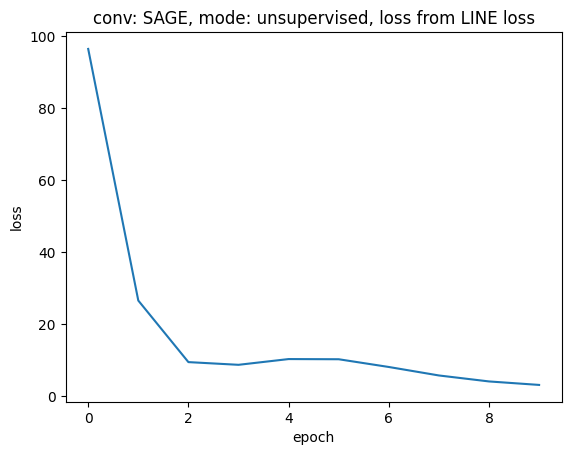

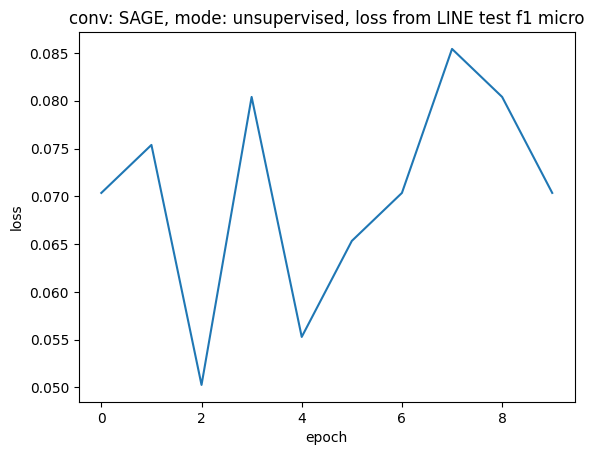

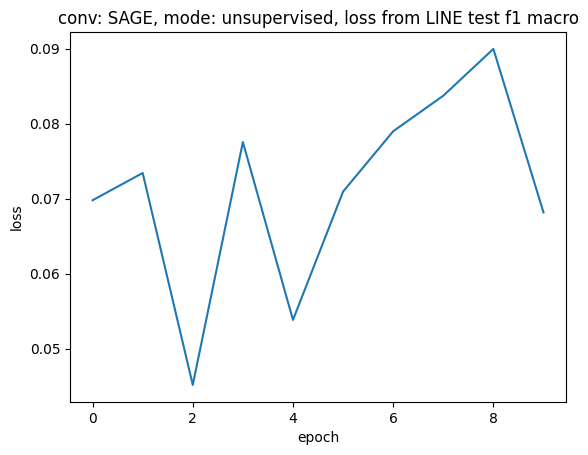

[I 2023-01-11 16:56:49,898] A new study created in memory with name: LINE loss,SAGE conv
[I 2023-01-11 16:56:58,977] Trial 0 finished with value: 0.02010075630518424 and parameters: {'hidden_layer': 64, 'out_layer': 64, 'dropout': 0.1, 'size of network, number of convs': 2, 'lr': 0.0064316699381962395, 'learning_rate_for_classifier': 0.007224232533661685, 'n_layers_for_classifier': 2, 'alpha_for_classifier': 0.001, 'hidden_layer_for_classifier': 128, 'num_negative_samples': 6, 'lmbda': 0.07579175929002213}. Best is trial 0 with value: 0.02010075630518424.
[I 2023-01-11 16:57:01,549] Trial 1 finished with value: 0.018321144496573776 and parameters: {'hidden_layer': 256, 'out_layer': 64, 'dropout': 0.5, 'size of network, number of convs': 1, 'lr': 0.007514442266888228, 'learning_rate_for_classifier': 0.005851474595419325, 'n_layers_for_classifier': 3, 'alpha_for_classifier': 0.5, 'hidden_layer_for_classifier': 64, 'num_negative_samples': 6, 'lmbda': 0.6895942325144554}. Best is trial 0 w

conv: SAGE, mode: unsupervised, loss from LINE
0
Loss: 7.9138, Epoch: 000, Train acc micro: 1.0000, Test acc micro: 0.0553,Train acc macro: 1.0000, Test acc macro: 0.0509
1


C:\Users\User\Desktop\Benchmarking-Loss-Functions\venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:699: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")


Loss: 3.5258, Epoch: 001, Train acc micro: 1.0000, Test acc micro: 0.0553,Train acc macro: 1.0000, Test acc macro: 0.0490
2
Loss: 3.7824, Epoch: 002, Train acc micro: 1.0000, Test acc micro: 0.0854,Train acc macro: 1.0000, Test acc macro: 0.0708
3
Loss: 3.2349, Epoch: 003, Train acc micro: 1.0000, Test acc micro: 0.0402,Train acc macro: 1.0000, Test acc macro: 0.0325
4
Loss: 2.6524, Epoch: 004, Train acc micro: 1.0000, Test acc micro: 0.0553,Train acc macro: 1.0000, Test acc macro: 0.0477
5
Loss: 2.3916, Epoch: 005, Train acc micro: 1.0000, Test acc micro: 0.0754,Train acc macro: 1.0000, Test acc macro: 0.0699
6
Loss: 2.2660, Epoch: 006, Train acc micro: 1.0000, Test acc micro: 0.0603,Train acc macro: 1.0000, Test acc macro: 0.0533
7
Loss: 2.2204, Epoch: 007, Train acc micro: 0.9929, Test acc micro: 0.0553,Train acc macro: 0.9928, Test acc macro: 0.0527
8
Loss: 2.2015, Epoch: 008, Train acc micro: 0.9943, Test acc micro: 0.0603,Train acc macro: 0.9942, Test acc macro: 0.0616
9
Loss: 2.

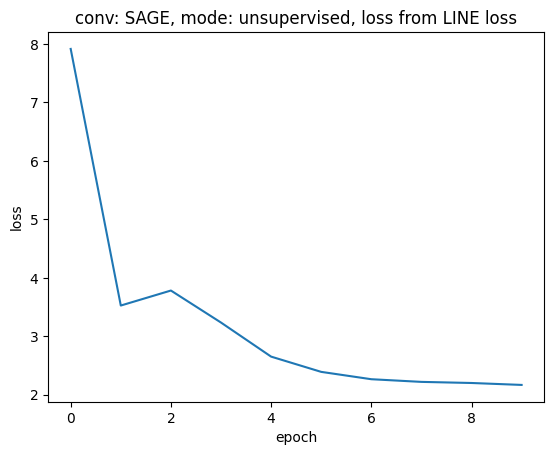

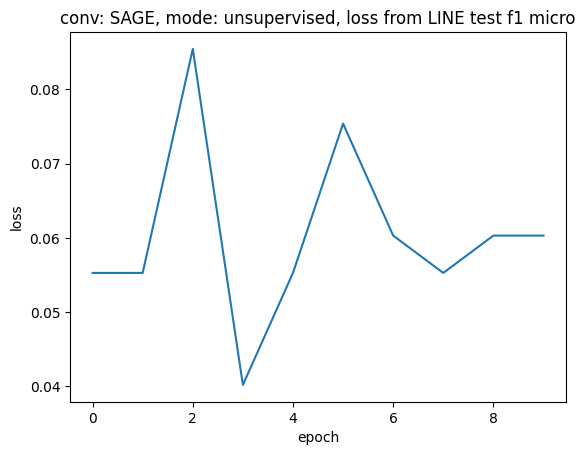

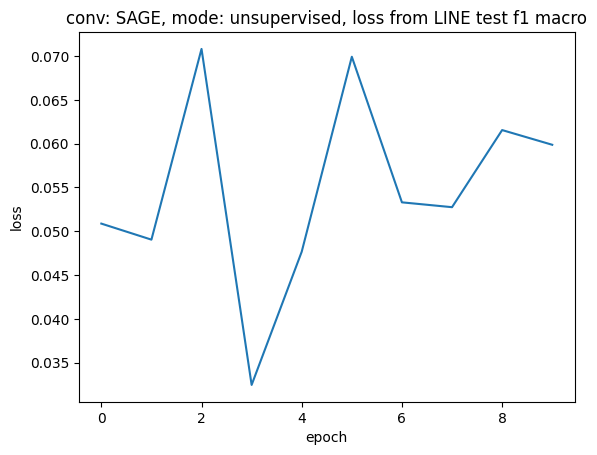

[I 2023-01-11 16:57:31,500] A new study created in memory with name: LINE loss,SAGE conv
[W 2023-01-11 16:57:32,024] Trial 0 failed because of the following error: KeyboardInterrupt()
Traceback (most recent call last):
  File "C:\Users\User\Desktop\Benchmarking-Loss-Functions\venv\lib\site-packages\optuna\study\_optimize.py", line 196, in _run_trial
    value_or_values = func(trial)
  File "C:\Users\User\AppData\Local\Temp\ipykernel_12916\3785168.py", line 50, in objective
    loss = self.train(model,self.data,optimizer,LossSampler,train_loader,dropout,epoch,loss_to_train)
  File "C:\Users\User\AppData\Local\Temp\ipykernel_12916\515202426.py", line 66, in train
    self.sampling(Sampler,epoch,n_id[:batch_size],loss)
  File "C:\Users\User\AppData\Local\Temp\ipykernel_12916\515202426.py", line 41, in sampling
    self.samples = Sampler.sample(nodes)
  File "C:\Users\User\Desktop\Benchmarking-Loss-Functions\modules\sampling.py", line 84, in sample
    return (self.pos_sample(batch), self.

KeyboardInterrupt: 

In [44]:
loss = LINE
loss_name = 'LINE'
device =torch.device('cuda' if torch.cuda.is_available() else 'cpu')

analysis = pd.read_csv('../results/classification_with_MLP.csv')
analysis = analysis.drop(columns = ['Unnamed: 0'])

for conv in ['SAGE','GCN','GAT']:
    for (l,f,cl,asp,ad) in datasets_names:
        name =  "".join(list(map(lambda x:str(x),  [l,f,cl,asp,ad])))
        if os.path.exists('../data_benchmark/graph_'+str(name)+'_attr.npy'):
                if len(analysis[ (analysis['loss'] == loss_name) & (analysis['conv'] == conv) & (analysis['dataset'] == name)] ) == 0:
                    MO = MainOptuna(name=name,conv=conv, device=device, loss_function=loss,mode= 'unsupervised')
                    best_values=MO.run(number_of_trials=500)

                    loss_trgt=dict()
                    for par in loss:
                        loss_trgt[par]=loss[par]

                    loss_trgt["num_negative_samples"] = best_values['num_negative_samples']
                    loss_trgt["lmbda"] = best_values['lmbda']

                    M = Main(name=name,conv=conv, device=device, loss_function=loss_trgt,mode= 'unsupervised')
                    train_acc_mi, test_acc_mi,train_acc_ma , test_acc_ma = M.run(best_values)

                    to_append=pd.Series([loss_name, conv, l,f,cl,asp,ad,name,train_acc_mi, test_acc_mi,train_acc_ma , test_acc_ma,best_values],index = analysis.columns)
                    analysis = analysis.append(to_append,ignore_index=True)
                    analysis.to_csv('../results/classification_with_MLP.csv')

[I 2023-01-11 17:04:50,005] A new study created in memory with name: HOPE_CommonNeighbors loss,SAGE conv
C:\Users\User\Desktop\Benchmarking-Loss-Functions\venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
[I 2023-01-11 17:04:52,915] Trial 0 finished with value: 0.07814888551507505 and parameters: {'hidden_layer': 128, 'out_layer': 32, 'dropout': 0.5, 'size of network, number of convs': 1, 'lr': 0.007935548436150646, 'learning_rate_for_classifier': 0.007820660970653186, 'n_layers_for_classifier': 2, 'alpha_for_classifier': 0.3, 'hidden_layer_for_classifier': 32, 'lmbda': 0.7676595004340275}. Best is trial 0 with value: 0.07814888551507505.
[I 2023-01-11 17:04:55,158] Trial 1 finished with value: 0.015430334996209192 and parameters: {'hidden_layer': 32, 'out_layer': 64, 'dropout': 0.5, 'size of network, number of convs': 2,

conv: SAGE, mode: unsupervised, loss from HOPE_CommonNeighbors
0


C:\Users\User\Desktop\Benchmarking-Loss-Functions\venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


Loss: 5722527.5000, Epoch: 000, Train acc micro: 1.0000, Test acc micro: 0.0553,Train acc macro: 1.0000, Test acc macro: 0.0545
1


C:\Users\User\Desktop\Benchmarking-Loss-Functions\venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


Loss: 2267008.0000, Epoch: 001, Train acc micro: 1.0000, Test acc micro: 0.0503,Train acc macro: 1.0000, Test acc macro: 0.0480
2


C:\Users\User\Desktop\Benchmarking-Loss-Functions\venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


Loss: 1336244.5000, Epoch: 002, Train acc micro: 1.0000, Test acc micro: 0.0402,Train acc macro: 1.0000, Test acc macro: 0.0415
3


C:\Users\User\Desktop\Benchmarking-Loss-Functions\venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


Loss: 1004679.1875, Epoch: 003, Train acc micro: 1.0000, Test acc micro: 0.0503,Train acc macro: 1.0000, Test acc macro: 0.0469
4


C:\Users\User\Desktop\Benchmarking-Loss-Functions\venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


Loss: 865170.1875, Epoch: 004, Train acc micro: 1.0000, Test acc micro: 0.0402,Train acc macro: 1.0000, Test acc macro: 0.0401
5


C:\Users\User\Desktop\Benchmarking-Loss-Functions\venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


Loss: 776181.5000, Epoch: 005, Train acc micro: 1.0000, Test acc micro: 0.0553,Train acc macro: 1.0000, Test acc macro: 0.0516
6
Loss: 698471.1875, Epoch: 006, Train acc micro: 1.0000, Test acc micro: 0.0704,Train acc macro: 1.0000, Test acc macro: 0.0702
7


C:\Users\User\Desktop\Benchmarking-Loss-Functions\venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


Loss: 615115.6250, Epoch: 007, Train acc micro: 1.0000, Test acc micro: 0.0854,Train acc macro: 1.0000, Test acc macro: 0.0828
8
Loss: 525011.4375, Epoch: 008, Train acc micro: 1.0000, Test acc micro: 0.0452,Train acc macro: 1.0000, Test acc macro: 0.0442
9
Loss: 438318.2188, Epoch: 009, Train acc micro: 1.0000, Test acc micro: 0.0653,Train acc macro: 1.0000, Test acc macro: 0.0666
Loss: 438318.2188, Epoch: 009, Train acc micro: 1.0000, Test acc micro: 0.0653,Train acc macro: 1.0000, Test acc macro: 0.0666


C:\Users\User\Desktop\Benchmarking-Loss-Functions\venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


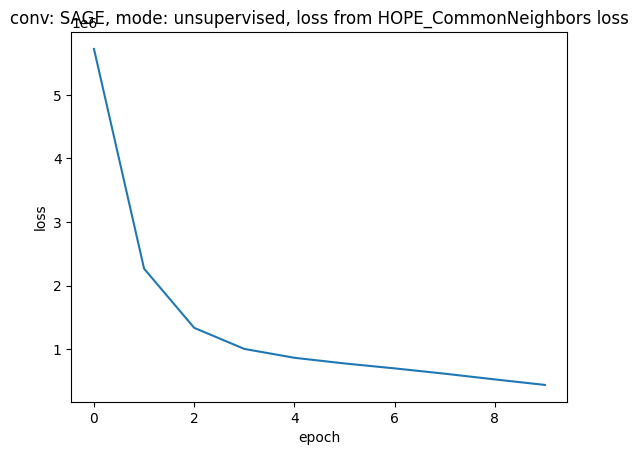

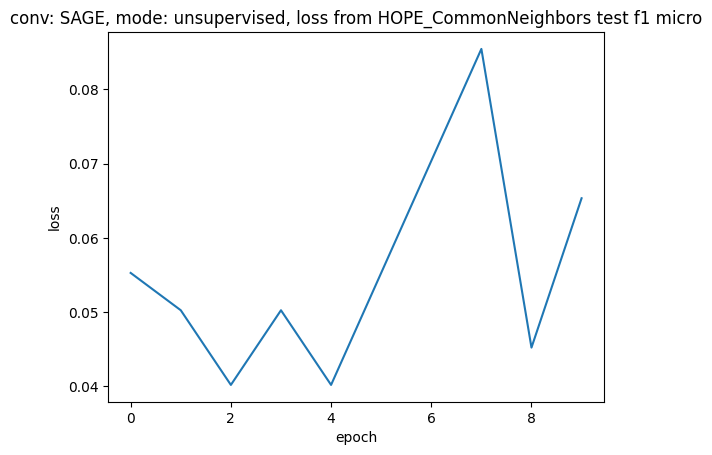

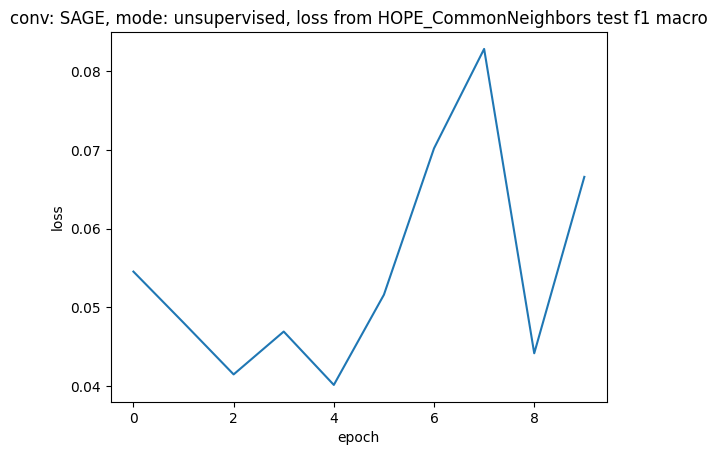

[I 2023-01-11 17:05:11,026] A new study created in memory with name: HOPE_CommonNeighbors loss,SAGE conv
[I 2023-01-11 17:05:13,366] Trial 0 finished with value: 0.012403473458920846 and parameters: {'hidden_layer': 64, 'out_layer': 32, 'dropout': 0.0, 'size of network, number of convs': 1, 'lr': 0.006681965168672557, 'learning_rate_for_classifier': 0.00908333711700326, 'n_layers_for_classifier': 3, 'alpha_for_classifier': 10, 'hidden_layer_for_classifier': 128, 'lmbda': 0.08102408987193443}. Best is trial 0 with value: 0.012403473458920846.
[W 2023-01-11 17:05:15,205] Trial 1 failed because of the following error: KeyboardInterrupt()
Traceback (most recent call last):
  File "C:\Users\User\Desktop\Benchmarking-Loss-Functions\venv\lib\site-packages\optuna\study\_optimize.py", line 196, in _run_trial
    value_or_values = func(trial)
  File "C:\Users\User\AppData\Local\Temp\ipykernel_12916\3785168.py", line 50, in objective
    loss = self.train(model,self.data,optimizer,LossSampler,tra

KeyboardInterrupt: 

In [50]:
loss = HOPE_CN
loss_name = 'HOPE_CN'
device =torch.device('cuda' if torch.cuda.is_available() else 'cpu')

analysis = pd.read_csv('../results/classification_with_MLP.csv')
analysis = analysis.drop(columns = ['Unnamed: 0'])

for conv in ['SAGE','GCN','GAT']:
    for (l,f,cl,asp,ad) in datasets_names:
        name =  "".join(list(map(lambda x:str(x),  [l,f,cl,asp,ad])))
        if os.path.exists('../data_benchmark/graph_'+str(name)+'_attr.npy'):
                if len(analysis[ (analysis['loss'] == loss_name) & (analysis['conv'] == conv) & (analysis['dataset'] == name)] ) == 0:

                    MO = MainOptuna(name=name,conv=conv, device=device, loss_function=loss,mode= 'unsupervised')
                    best_values=MO.run(number_of_trials=500)

                    loss_trgt=dict()
                    for par in loss:
                        loss_trgt[par]=loss[par]


                    loss_trgt["lmbda"] = best_values['lmbda']

                    M = Main(name=name,conv=conv, device=device, loss_function=loss_trgt,mode= 'unsupervised')
                    train_acc_mi, test_acc_mi,train_acc_ma , test_acc_ma = M.run(best_values)

                    to_append=pd.Series([loss_name, conv, l,f,cl,asp,ad,name,train_acc_mi, test_acc_mi,train_acc_ma , test_acc_ma,best_values],index = analysis.columns)
                    analysis = analysis.append(to_append,ignore_index=True)
                    analysis.to_csv('../results/classification_with_MLP.csv')


[I 2023-01-11 17:01:40,347] A new study created in memory with name: VERSE_Adj loss,SAGE conv
[I 2023-01-11 17:01:50,982] Trial 0 finished with value: 0.012403473458920846 and parameters: {'hidden_layer': 32, 'out_layer': 32, 'dropout': 0.4, 'size of network, number of convs': 3, 'lr': 0.005328078051834754, 'learning_rate_for_classifier': 0.009354282622142811, 'n_layers_for_classifier': 2, 'alpha_for_classifier': 20, 'hidden_layer_for_classifier': 128, 'num_negative_samples': 11, 'lmbda': 0.4216804422852044}. Best is trial 0 with value: 0.012403473458920846.
[I 2023-01-11 17:01:54,384] Trial 1 finished with value: 0.017541160386140585 and parameters: {'hidden_layer': 128, 'out_layer': 64, 'dropout': 0.2, 'size of network, number of convs': 2, 'lr': 0.0065527769132247985, 'learning_rate_for_classifier': 0.006572015851639273, 'n_layers_for_classifier': 3, 'alpha_for_classifier': 0.7, 'hidden_layer_for_classifier': 256, 'num_negative_samples': 16, 'lmbda': 0.6179519256144075}. Best is tri

conv: SAGE, mode: unsupervised, loss from VERSE_Adj
0
Loss: 13.6021, Epoch: 000, Train acc micro: 1.0000, Test acc micro: 0.0653,Train acc macro: 1.0000, Test acc macro: 0.0667
1
Loss: 11.9973, Epoch: 001, Train acc micro: 1.0000, Test acc micro: 0.0704,Train acc macro: 1.0000, Test acc macro: 0.0640
2
Loss: 4.2955, Epoch: 002, Train acc micro: 0.9943, Test acc micro: 0.0503,Train acc macro: 0.9943, Test acc macro: 0.0423
3
Loss: 2.1965, Epoch: 003, Train acc micro: 0.9458, Test acc micro: 0.0503,Train acc macro: 0.9461, Test acc macro: 0.0453
4
Loss: 1.7115, Epoch: 004, Train acc micro: 0.8959, Test acc micro: 0.0653,Train acc macro: 0.8968, Test acc macro: 0.0573
5
Loss: 1.5473, Epoch: 005, Train acc micro: 0.8103, Test acc micro: 0.0452,Train acc macro: 0.8154, Test acc macro: 0.0355
6
Loss: 1.4454, Epoch: 006, Train acc micro: 0.7504, Test acc micro: 0.0503,Train acc macro: 0.7561, Test acc macro: 0.0355
7
Loss: 1.3642, Epoch: 007, Train acc micro: 0.6690, Test acc micro: 0.0603,Tr

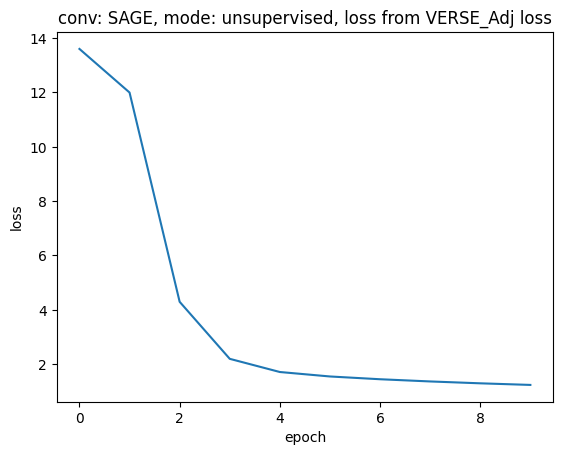

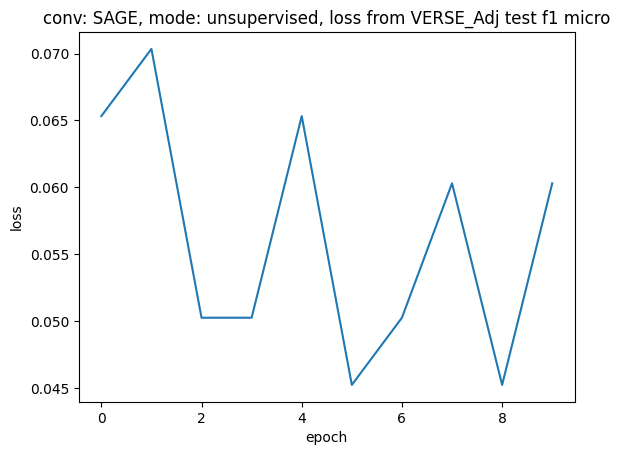

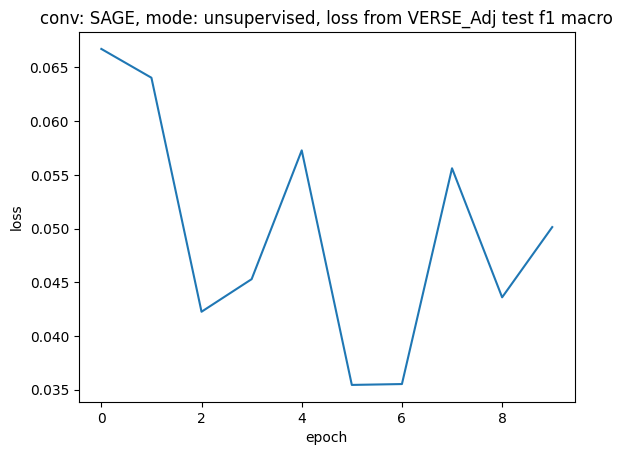

[I 2023-01-11 17:02:10,868] A new study created in memory with name: VERSE_Adj loss,SAGE conv
[I 2023-01-11 17:02:22,791] Trial 0 finished with value: 0.03622643112913984 and parameters: {'hidden_layer': 32, 'out_layer': 32, 'dropout': 0.2, 'size of network, number of convs': 2, 'lr': 0.006676808688186331, 'learning_rate_for_classifier': 0.006718306061703813, 'n_layers_for_classifier': 2, 'alpha_for_classifier': 0.001, 'hidden_layer_for_classifier': 128, 'num_negative_samples': 21, 'lmbda': 0.12415718638602435}. Best is trial 0 with value: 0.03622643112913984.
[I 2023-01-11 17:02:23,395] Trial 1 finished with value: 0.014332996288588638 and parameters: {'hidden_layer': 128, 'out_layer': 64, 'dropout': 0.30000000000000004, 'size of network, number of convs': 2, 'lr': 0.009576678287985994, 'learning_rate_for_classifier': 0.0090697220580848, 'n_layers_for_classifier': 1, 'alpha_for_classifier': 0.9, 'hidden_layer_for_classifier': 32, 'num_negative_samples': 16, 'lmbda': 0.4457823634137069

conv: SAGE, mode: unsupervised, loss from VERSE_Adj
0


C:\Users\User\Desktop\Benchmarking-Loss-Functions\venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


Loss: 2.9377, Epoch: 000, Train acc micro: 0.5178, Test acc micro: 0.0503,Train acc macro: 0.5125, Test acc macro: 0.0430
1


C:\Users\User\Desktop\Benchmarking-Loss-Functions\venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


Loss: 2.0431, Epoch: 001, Train acc micro: 0.4979, Test acc micro: 0.0553,Train acc macro: 0.4950, Test acc macro: 0.0480
2


C:\Users\User\Desktop\Benchmarking-Loss-Functions\venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


Loss: 1.7557, Epoch: 002, Train acc micro: 0.4337, Test acc micro: 0.0754,Train acc macro: 0.4284, Test acc macro: 0.0617
3


C:\Users\User\Desktop\Benchmarking-Loss-Functions\venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


Loss: 1.2544, Epoch: 003, Train acc micro: 0.4123, Test acc micro: 0.0503,Train acc macro: 0.4082, Test acc macro: 0.0423
4


C:\Users\User\Desktop\Benchmarking-Loss-Functions\venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


Loss: 1.0170, Epoch: 004, Train acc micro: 0.3752, Test acc micro: 0.0653,Train acc macro: 0.3695, Test acc macro: 0.0610
5


C:\Users\User\Desktop\Benchmarking-Loss-Functions\venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


Loss: 0.9301, Epoch: 005, Train acc micro: 0.3167, Test acc micro: 0.0754,Train acc macro: 0.3143, Test acc macro: 0.0729
6
Loss: 0.8932, Epoch: 006, Train acc micro: 0.3352, Test acc micro: 0.0653,Train acc macro: 0.3313, Test acc macro: 0.0578
7
Loss: 0.8826, Epoch: 007, Train acc micro: 0.3096, Test acc micro: 0.0905,Train acc macro: 0.3077, Test acc macro: 0.0820
8
Loss: 0.8759, Epoch: 008, Train acc micro: 0.2896, Test acc micro: 0.0754,Train acc macro: 0.2871, Test acc macro: 0.0756
9
Loss: 0.8656, Epoch: 009, Train acc micro: 0.3096, Test acc micro: 0.0704,Train acc macro: 0.3099, Test acc macro: 0.0681
Loss: 0.8656, Epoch: 009, Train acc micro: 0.3096, Test acc micro: 0.0704,Train acc macro: 0.3099, Test acc macro: 0.0681


C:\Users\User\Desktop\Benchmarking-Loss-Functions\venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


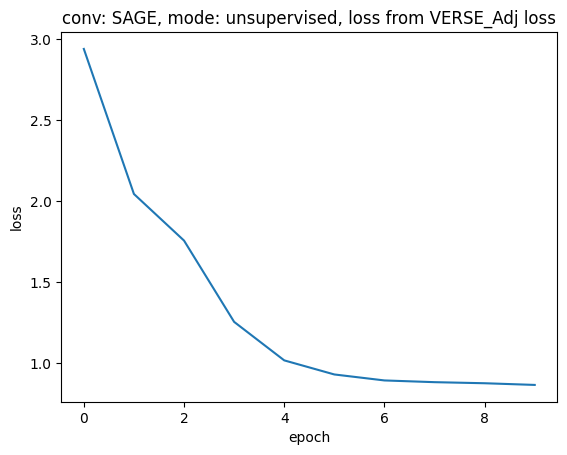

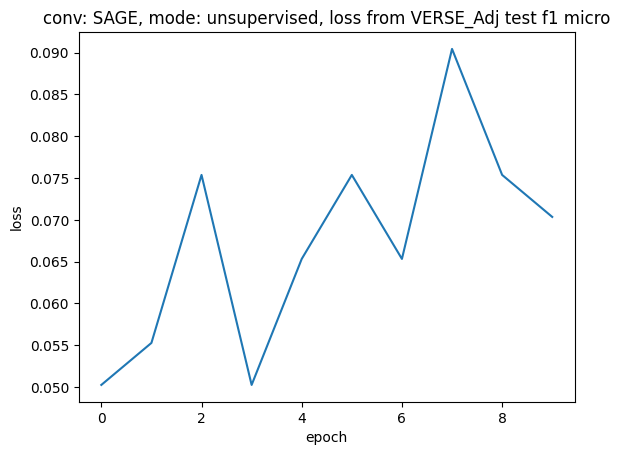

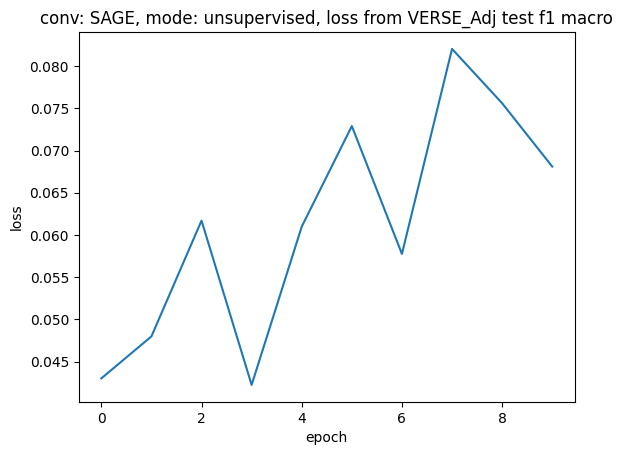

[I 2023-01-11 17:02:32,066] A new study created in memory with name: VERSE_Adj loss,SAGE conv
[I 2023-01-11 17:02:44,256] Trial 0 finished with value: 0.02701096941471934 and parameters: {'hidden_layer': 256, 'out_layer': 64, 'dropout': 0.5, 'size of network, number of convs': 3, 'lr': 0.00604025109293471, 'learning_rate_for_classifier': 0.008796830610528501, 'n_layers_for_classifier': 3, 'alpha_for_classifier': 0.1, 'hidden_layer_for_classifier': 64, 'num_negative_samples': 16, 'lmbda': 0.5109310666186191}. Best is trial 0 with value: 0.02701096941471934.
C:\Users\User\Desktop\Benchmarking-Loss-Functions\venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
[I 2023-01-11 17:02:45,535] Trial 1 finished with value: 0.12836874757329117 and parameters: {'hidden_layer': 128, 'out_layer': 64, 'dropout': 0.5, 'size of network, numb

conv: SAGE, mode: unsupervised, loss from VERSE_Adj
0


C:\Users\User\Desktop\Benchmarking-Loss-Functions\venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


Loss: 7.3217, Epoch: 000, Train acc micro: 1.0000, Test acc micro: 0.0704,Train acc macro: 1.0000, Test acc macro: 0.0745
1


C:\Users\User\Desktop\Benchmarking-Loss-Functions\venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


Loss: 3.8603, Epoch: 001, Train acc micro: 1.0000, Test acc micro: 0.0503,Train acc macro: 1.0000, Test acc macro: 0.0508
2


C:\Users\User\Desktop\Benchmarking-Loss-Functions\venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


Loss: 3.0136, Epoch: 002, Train acc micro: 1.0000, Test acc micro: 0.0553,Train acc macro: 1.0000, Test acc macro: 0.0527
3


C:\Users\User\Desktop\Benchmarking-Loss-Functions\venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


Loss: 2.5725, Epoch: 003, Train acc micro: 1.0000, Test acc micro: 0.0553,Train acc macro: 1.0000, Test acc macro: 0.0520
4


C:\Users\User\Desktop\Benchmarking-Loss-Functions\venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


Loss: 2.1796, Epoch: 004, Train acc micro: 1.0000, Test acc micro: 0.0503,Train acc macro: 1.0000, Test acc macro: 0.0459
5


C:\Users\User\Desktop\Benchmarking-Loss-Functions\venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


Loss: 1.9481, Epoch: 005, Train acc micro: 1.0000, Test acc micro: 0.0754,Train acc macro: 1.0000, Test acc macro: 0.0756
6


C:\Users\User\Desktop\Benchmarking-Loss-Functions\venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


Loss: 1.8202, Epoch: 006, Train acc micro: 1.0000, Test acc micro: 0.0553,Train acc macro: 1.0000, Test acc macro: 0.0518
7


C:\Users\User\Desktop\Benchmarking-Loss-Functions\venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


Loss: 1.6701, Epoch: 007, Train acc micro: 1.0000, Test acc micro: 0.0402,Train acc macro: 1.0000, Test acc macro: 0.0410
8


C:\Users\User\Desktop\Benchmarking-Loss-Functions\venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


Loss: 1.4846, Epoch: 008, Train acc micro: 1.0000, Test acc micro: 0.0553,Train acc macro: 1.0000, Test acc macro: 0.0564
9
Loss: 1.3065, Epoch: 009, Train acc micro: 1.0000, Test acc micro: 0.0603,Train acc macro: 1.0000, Test acc macro: 0.0610
Loss: 1.3065, Epoch: 009, Train acc micro: 1.0000, Test acc micro: 0.0603,Train acc macro: 1.0000, Test acc macro: 0.0610


C:\Users\User\Desktop\Benchmarking-Loss-Functions\venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


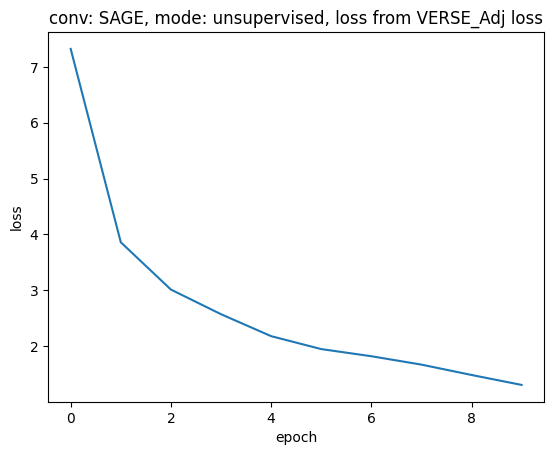

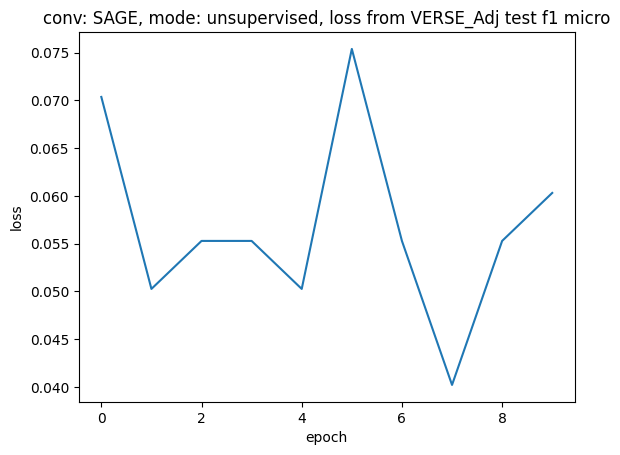

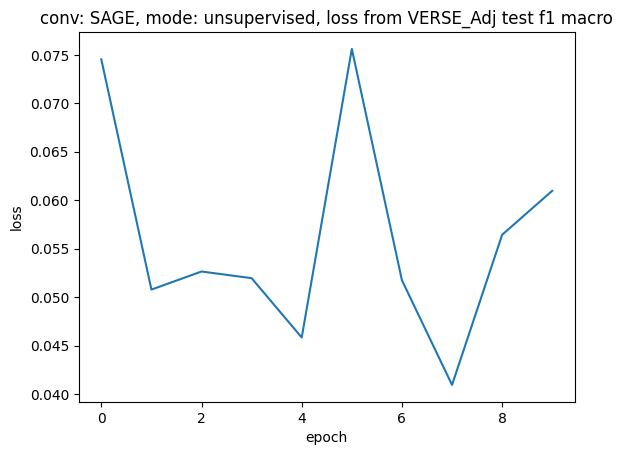

[I 2023-01-11 17:02:57,863] A new study created in memory with name: VERSE_Adj loss,SAGE conv
[I 2023-01-11 17:03:09,162] Trial 0 finished with value: 0.03222243803801767 and parameters: {'hidden_layer': 32, 'out_layer': 32, 'dropout': 0.0, 'size of network, number of convs': 3, 'lr': 0.005338615845405475, 'learning_rate_for_classifier': 0.006417357076970944, 'n_layers_for_classifier': 3, 'alpha_for_classifier': 0.9, 'hidden_layer_for_classifier': 64, 'num_negative_samples': 21, 'lmbda': 0.06151391116015403}. Best is trial 0 with value: 0.03222243803801767.
C:\Users\User\Desktop\Benchmarking-Loss-Functions\venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
[I 2023-01-11 17:03:10,697] Trial 1 finished with value: 0.0406464851141738 and parameters: {'hidden_layer': 32, 'out_layer': 64, 'dropout': 0.0, 'size of network, numbe

conv: SAGE, mode: unsupervised, loss from VERSE_Adj
0
Loss: 9.1776, Epoch: 000, Train acc micro: 1.0000, Test acc micro: 0.0402,Train acc macro: 1.0000, Test acc macro: 0.0416
1
Loss: 3.2853, Epoch: 001, Train acc micro: 1.0000, Test acc micro: 0.0553,Train acc macro: 1.0000, Test acc macro: 0.0561
2
Loss: 2.1271, Epoch: 002, Train acc micro: 1.0000, Test acc micro: 0.0302,Train acc macro: 1.0000, Test acc macro: 0.0302
3
Loss: 2.0047, Epoch: 003, Train acc micro: 1.0000, Test acc micro: 0.0503,Train acc macro: 1.0000, Test acc macro: 0.0578
4
Loss: 1.9311, Epoch: 004, Train acc micro: 1.0000, Test acc micro: 0.0503,Train acc macro: 1.0000, Test acc macro: 0.0479
5
Loss: 1.8664, Epoch: 005, Train acc micro: 1.0000, Test acc micro: 0.0603,Train acc macro: 1.0000, Test acc macro: 0.0646
6
Loss: 1.7957, Epoch: 006, Train acc micro: 1.0000, Test acc micro: 0.0804,Train acc macro: 1.0000, Test acc macro: 0.0792
7
Loss: 1.6867, Epoch: 007, Train acc micro: 1.0000, Test acc micro: 0.0553,Trai

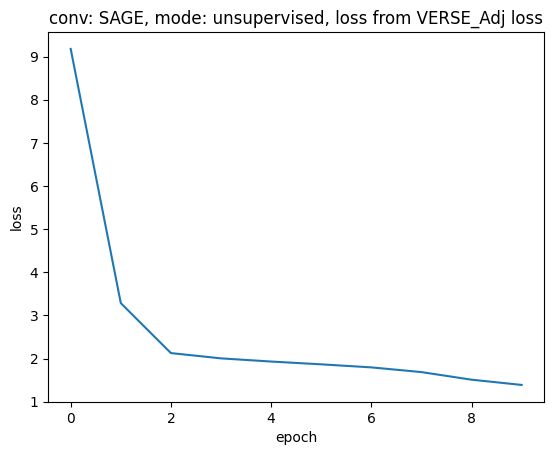

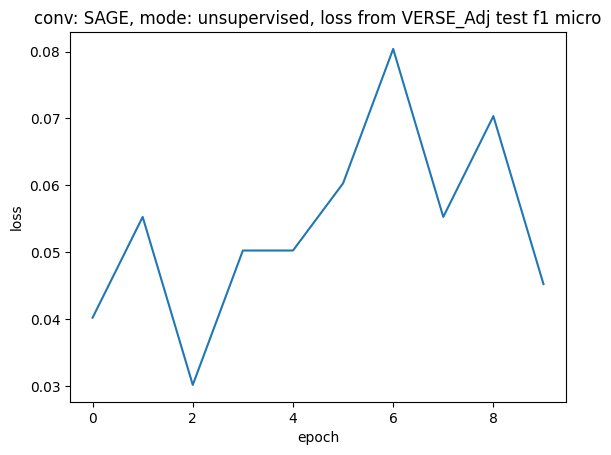

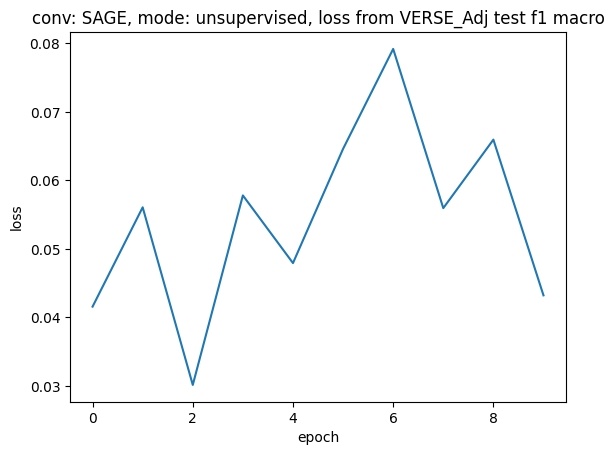

[I 2023-01-11 17:03:20,593] A new study created in memory with name: VERSE_Adj loss,SAGE conv
[I 2023-01-11 17:03:31,445] Trial 0 finished with value: 0.0486937286843437 and parameters: {'hidden_layer': 32, 'out_layer': 32, 'dropout': 0.30000000000000004, 'size of network, number of convs': 2, 'lr': 0.00942249729888181, 'learning_rate_for_classifier': 0.007940505705432588, 'n_layers_for_classifier': 2, 'alpha_for_classifier': 0.1, 'hidden_layer_for_classifier': 64, 'num_negative_samples': 16, 'lmbda': 0.7606533191196632}. Best is trial 0 with value: 0.0486937286843437.
[I 2023-01-11 17:03:32,207] Trial 1 finished with value: 0.021279807063957257 and parameters: {'hidden_layer': 32, 'out_layer': 64, 'dropout': 0.4, 'size of network, number of convs': 1, 'lr': 0.008685866726505885, 'learning_rate_for_classifier': 0.0052360155468396076, 'n_layers_for_classifier': 2, 'alpha_for_classifier': 20, 'hidden_layer_for_classifier': 128, 'num_negative_samples': 16, 'lmbda': 0.5333834313787252}. Be

conv: SAGE, mode: unsupervised, loss from VERSE_Adj
0
Loss: 5.0873, Epoch: 000, Train acc micro: 0.6006, Test acc micro: 0.1055,Train acc macro: 0.5995, Test acc macro: 0.1033
1
Loss: 2.2134, Epoch: 001, Train acc micro: 0.5621, Test acc micro: 0.0754,Train acc macro: 0.5622, Test acc macro: 0.0695
2
Loss: 1.7409, Epoch: 002, Train acc micro: 0.6106, Test acc micro: 0.1005,Train acc macro: 0.6107, Test acc macro: 0.0994
3
Loss: 1.4860, Epoch: 003, Train acc micro: 0.5378, Test acc micro: 0.0754,Train acc macro: 0.5364, Test acc macro: 0.0745
4


C:\Users\User\Desktop\Benchmarking-Loss-Functions\venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


Loss: 1.3673, Epoch: 004, Train acc micro: 0.6220, Test acc micro: 0.0804,Train acc macro: 0.6180, Test acc macro: 0.0720
5


C:\Users\User\Desktop\Benchmarking-Loss-Functions\venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


Loss: 1.2627, Epoch: 005, Train acc micro: 0.5877, Test acc micro: 0.0854,Train acc macro: 0.5830, Test acc macro: 0.0713
6
Loss: 1.1871, Epoch: 006, Train acc micro: 0.5478, Test acc micro: 0.0603,Train acc macro: 0.5422, Test acc macro: 0.0573
7


C:\Users\User\Desktop\Benchmarking-Loss-Functions\venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


Loss: 1.1556, Epoch: 007, Train acc micro: 0.5478, Test acc micro: 0.0503,Train acc macro: 0.5436, Test acc macro: 0.0449
8


C:\Users\User\Desktop\Benchmarking-Loss-Functions\venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


Loss: 1.1355, Epoch: 008, Train acc micro: 0.5407, Test acc micro: 0.0854,Train acc macro: 0.5395, Test acc macro: 0.0784
9
Loss: 1.1189, Epoch: 009, Train acc micro: 0.5350, Test acc micro: 0.0854,Train acc macro: 0.5315, Test acc macro: 0.0848
Loss: 1.1189, Epoch: 009, Train acc micro: 0.5350, Test acc micro: 0.0854,Train acc macro: 0.5315, Test acc macro: 0.0848


C:\Users\User\Desktop\Benchmarking-Loss-Functions\venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


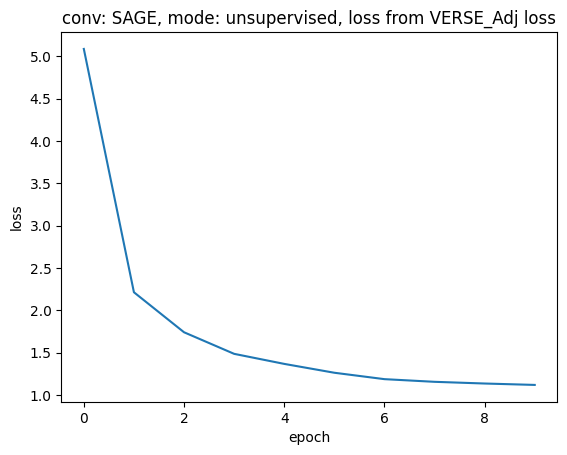

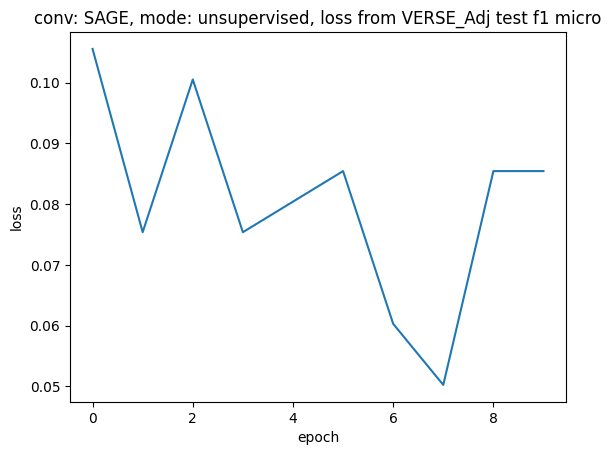

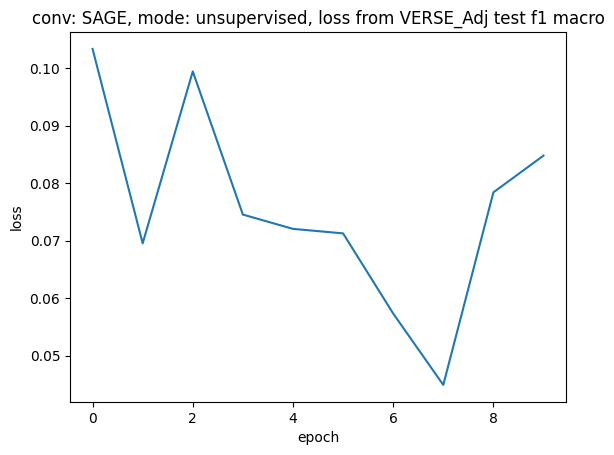

[I 2023-01-11 17:03:47,891] A new study created in memory with name: VERSE_Adj loss,SAGE conv
C:\Users\User\Desktop\Benchmarking-Loss-Functions\venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
[I 2023-01-11 17:03:58,843] Trial 0 finished with value: 0.07195181950448165 and parameters: {'hidden_layer': 64, 'out_layer': 64, 'dropout': 0.4, 'size of network, number of convs': 3, 'lr': 0.008573895787932087, 'learning_rate_for_classifier': 0.007280747257583391, 'n_layers_for_classifier': 1, 'alpha_for_classifier': 0.01, 'hidden_layer_for_classifier': 32, 'num_negative_samples': 11, 'lmbda': 0.3268109532202439}. Best is trial 0 with value: 0.07195181950448165.
[I 2023-01-11 17:04:00,078] Trial 1 finished with value: 0.024494897427831782 and parameters: {'hidden_layer': 64, 'out_layer': 32, 'dropout': 0.4, 'size of network, num

conv: SAGE, mode: unsupervised, loss from VERSE_Adj
0


C:\Users\User\Desktop\Benchmarking-Loss-Functions\venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


Loss: 3.7280, Epoch: 000, Train acc micro: 0.6762, Test acc micro: 0.0804,Train acc macro: 0.6737, Test acc macro: 0.0850
1


C:\Users\User\Desktop\Benchmarking-Loss-Functions\venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


Loss: 1.7810, Epoch: 001, Train acc micro: 0.6034, Test acc micro: 0.1156,Train acc macro: 0.5989, Test acc macro: 0.1094
2


C:\Users\User\Desktop\Benchmarking-Loss-Functions\venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


Loss: 1.2600, Epoch: 002, Train acc micro: 0.5521, Test acc micro: 0.1256,Train acc macro: 0.5505, Test acc macro: 0.1233
3


C:\Users\User\Desktop\Benchmarking-Loss-Functions\venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


Loss: 1.1319, Epoch: 003, Train acc micro: 0.3852, Test acc micro: 0.0854,Train acc macro: 0.3759, Test acc macro: 0.0803
4


C:\Users\User\Desktop\Benchmarking-Loss-Functions\venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


Loss: 1.0840, Epoch: 004, Train acc micro: 0.3295, Test acc micro: 0.0955,Train acc macro: 0.3274, Test acc macro: 0.0799
5


C:\Users\User\Desktop\Benchmarking-Loss-Functions\venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


Loss: 1.0593, Epoch: 005, Train acc micro: 0.3181, Test acc micro: 0.0905,Train acc macro: 0.3127, Test acc macro: 0.0881
6


C:\Users\User\Desktop\Benchmarking-Loss-Functions\venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


Loss: 1.0451, Epoch: 006, Train acc micro: 0.3067, Test acc micro: 0.1005,Train acc macro: 0.3041, Test acc macro: 0.0933
7


C:\Users\User\Desktop\Benchmarking-Loss-Functions\venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


Loss: 1.0385, Epoch: 007, Train acc micro: 0.3224, Test acc micro: 0.1005,Train acc macro: 0.3199, Test acc macro: 0.0973
8


C:\Users\User\Desktop\Benchmarking-Loss-Functions\venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


Loss: 1.0327, Epoch: 008, Train acc micro: 0.2996, Test acc micro: 0.0653,Train acc macro: 0.2948, Test acc macro: 0.0550
9
Loss: 1.0235, Epoch: 009, Train acc micro: 0.3010, Test acc micro: 0.0653,Train acc macro: 0.2959, Test acc macro: 0.0551
Loss: 1.0235, Epoch: 009, Train acc micro: 0.3010, Test acc micro: 0.0653,Train acc macro: 0.2959, Test acc macro: 0.0551


C:\Users\User\Desktop\Benchmarking-Loss-Functions\venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


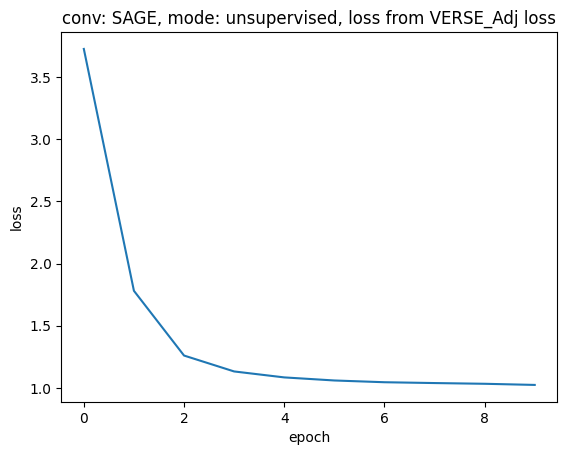

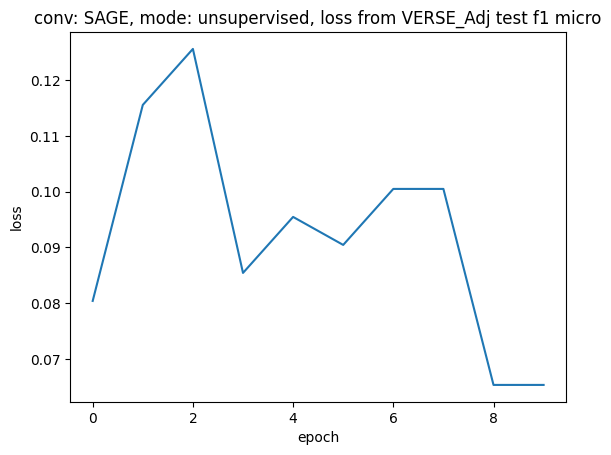

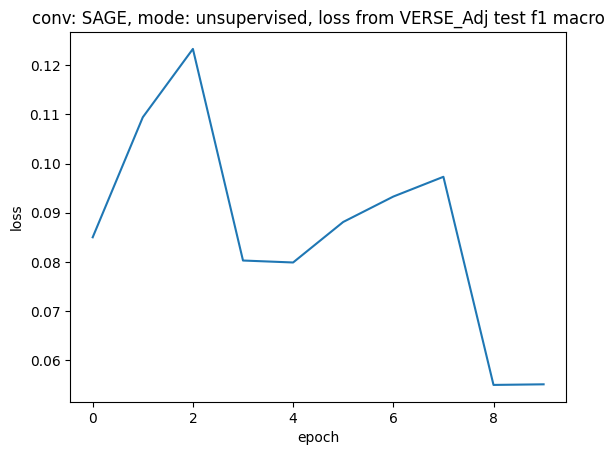

[I 2023-01-11 17:04:13,345] A new study created in memory with name: VERSE_Adj loss,SAGE conv
[I 2023-01-11 17:04:23,643] Trial 0 finished with value: 0.0188484258731263 and parameters: {'hidden_layer': 32, 'out_layer': 128, 'dropout': 0.4, 'size of network, number of convs': 3, 'lr': 0.00653206745094827, 'learning_rate_for_classifier': 0.007867093334872614, 'n_layers_for_classifier': 2, 'alpha_for_classifier': 0.5, 'hidden_layer_for_classifier': 64, 'num_negative_samples': 6, 'lmbda': 0.3769103517248754}. Best is trial 0 with value: 0.0188484258731263.
[I 2023-01-11 17:04:24,067] Trial 1 finished with value: 0.009393364366277242 and parameters: {'hidden_layer': 32, 'out_layer': 64, 'dropout': 0.30000000000000004, 'size of network, number of convs': 2, 'lr': 0.009548609970688283, 'learning_rate_for_classifier': 0.005803414308608071, 'n_layers_for_classifier': 1, 'alpha_for_classifier': 10, 'hidden_layer_for_classifier': 32, 'num_negative_samples': 1, 'lmbda': 0.6922394926543373}. Best 

conv: SAGE, mode: unsupervised, loss from VERSE_Adj
0
Loss: 2.4602, Epoch: 000, Train acc micro: 0.9971, Test acc micro: 0.0503,Train acc macro: 0.9972, Test acc macro: 0.0480
1
Loss: 1.5901, Epoch: 001, Train acc micro: 0.9715, Test acc micro: 0.0553,Train acc macro: 0.9714, Test acc macro: 0.0352
2
Loss: 1.4401, Epoch: 002, Train acc micro: 0.9529, Test acc micro: 0.0402,Train acc macro: 0.9531, Test acc macro: 0.0322
3
Loss: 1.3665, Epoch: 003, Train acc micro: 0.9201, Test acc micro: 0.0553,Train acc macro: 0.9205, Test acc macro: 0.0329
4
Loss: 1.2984, Epoch: 004, Train acc micro: 0.9387, Test acc micro: 0.0352,Train acc macro: 0.9394, Test acc macro: 0.0323
5
Loss: 1.2645, Epoch: 005, Train acc micro: 0.9258, Test acc micro: 0.0653,Train acc macro: 0.9250, Test acc macro: 0.0560
6
Loss: 1.2168, Epoch: 006, Train acc micro: 0.9272, Test acc micro: 0.0503,Train acc macro: 0.9275, Test acc macro: 0.0414
7
Loss: 1.1954, Epoch: 007, Train acc micro: 0.9058, Test acc micro: 0.0503,Trai

C:\Users\User\Desktop\Benchmarking-Loss-Functions\venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:699: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")


Loss: 1.1714, Epoch: 008, Train acc micro: 0.3267, Test acc micro: 0.0603,Train acc macro: 0.3194, Test acc macro: 0.0478
9
Loss: 1.1548, Epoch: 009, Train acc micro: 0.8573, Test acc micro: 0.0653,Train acc macro: 0.8570, Test acc macro: 0.0564
Loss: 1.1548, Epoch: 009, Train acc micro: 0.8573, Test acc micro: 0.0653,Train acc macro: 0.8570, Test acc macro: 0.0564


C:\Users\User\Desktop\Benchmarking-Loss-Functions\venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:699: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")


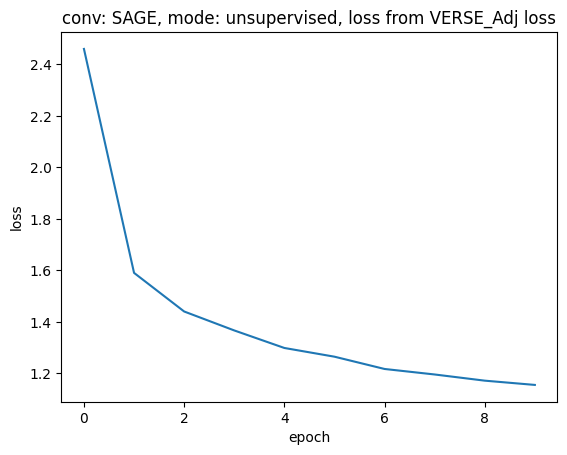

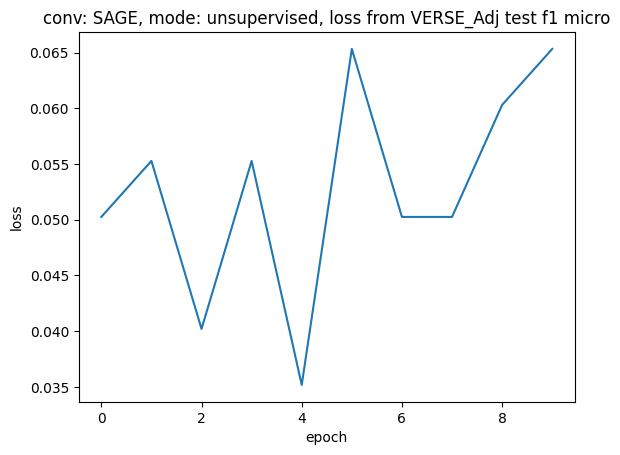

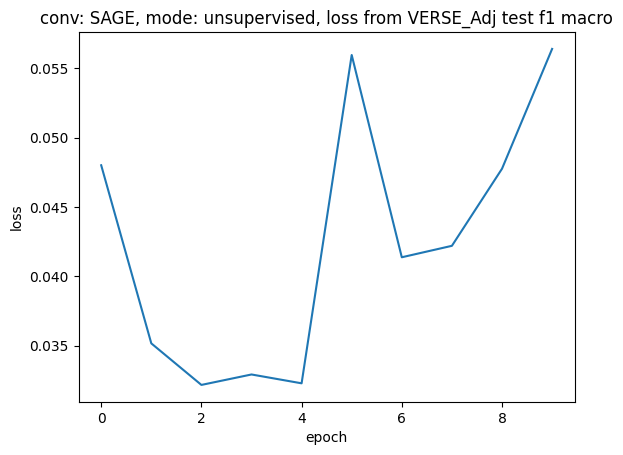

[I 2023-01-11 17:04:47,908] A new study created in memory with name: VERSE_Adj loss,SAGE conv
[W 2023-01-11 17:04:48,306] Trial 0 failed because of the following error: KeyboardInterrupt()
Traceback (most recent call last):
  File "C:\Users\User\Desktop\Benchmarking-Loss-Functions\venv\lib\site-packages\optuna\study\_optimize.py", line 196, in _run_trial
    value_or_values = func(trial)
  File "C:\Users\User\AppData\Local\Temp\ipykernel_12916\3785168.py", line 50, in objective
    loss = self.train(model,self.data,optimizer,LossSampler,train_loader,dropout,epoch,loss_to_train)
  File "C:\Users\User\AppData\Local\Temp\ipykernel_12916\515202426.py", line 66, in train
    self.sampling(Sampler,epoch,n_id[:batch_size],loss)
  File "C:\Users\User\AppData\Local\Temp\ipykernel_12916\515202426.py", line 41, in sampling
    self.samples = Sampler.sample(nodes)
  File "C:\Users\User\Desktop\Benchmarking-Loss-Functions\modules\sampling.py", line 84, in sample
    return (self.pos_sample(batch), 

KeyboardInterrupt: 

In [49]:
loss = VERSE_Adj
loss_name = 'VERSE_Adj'
device =torch.device('cuda' if torch.cuda.is_available() else 'cpu')
analysis = pd.read_csv('../results/classification_with_MLP.csv')
analysis = analysis.drop(columns = ['Unnamed: 0'])

for conv in ['SAGE','GCN','GAT']:
    for (l,f,cl,asp,ad) in datasets_names:
        name =  "".join(list(map(lambda x:str(x),  [l,f,cl,asp,ad])))
        if os.path.exists('../data_benchmark/graph_'+str(name)+'_attr.npy'):
                if len(analysis[ (analysis['loss'] == loss_name) & (analysis['conv'] == conv) & (analysis['dataset'] == name)] ) == 0:

                    MO = MainOptuna(name=name,conv=conv, device=device, loss_function=loss,mode= 'unsupervised')
                    best_values=MO.run(number_of_trials=500)

                    loss_trgt=dict()
                    for par in loss:
                        loss_trgt[par]=loss[par]

                    loss_trgt["num_negative_samples"] = best_values['num_negative_samples']
                    loss_trgt["lmbda"] = best_values['lmbda']

                    M = Main(name=name,conv=conv, device=device, loss_function=loss_trgt,mode= 'unsupervised')
                    train_acc_mi, test_acc_mi,train_acc_ma , test_acc_ma = M.run(best_values)
                    to_append=pd.Series([loss_name, conv, l,f,cl,asp,ad,name,train_acc_mi, test_acc_mi,train_acc_ma , test_acc_ma,best_values],index = analysis.columns)
                    analysis = analysis.append(to_append,ignore_index=True)
                    analysis.to_csv('../results/classification_with_MLP.csv')

# ниже надо еще редактировать

In [14]:
loss = LapEigen
loss_name = 'LapEigen'
device =torch.device('cuda' if torch.cuda.is_available() else 'cpu')
analysis = pd.read_csv('../results/classification_catboost.csv')

for name in datasets_names[:2]:
    for conv in ['GCN']:
            if len(analysis[ (analysis['loss'] == loss_name) & (analysis['conv'] == conv) & (analysis['dataset'] == name)] ) == 0:

                MO = MainOptuna(name=name,conv=conv, device=device, loss_function=loss,mode= 'unsupervised')
                best_values=MO.run(number_of_trials=500)

                loss_trgt=dict()
                for par in loss:
                    loss_trgt[par]=loss[par]


                loss_trgt["lmbda"] = best_values['lmbda']


                M = Main(name=name,conv=conv, device=device, loss_function=loss_trgt,mode= 'unsupervised')
                train_acc_mi, test_acc_mi,train_acc_ma , test_acc_ma = M.run(best_values)

                to_append=pd.Series([loss_name, conv,name, train_acc_mi, test_acc_mi,train_acc_ma , test_acc_ma],index = analysis.columns)
                analysis = analysis.append(to_append,ignore_index=True)
                analysis.to_csv('../results/classification_catboost.csv')


[I 2022-11-08 02:22:44,782] A new study created in memory with name: LaplacianEigenMaps loss,GCN conv
[I 2022-11-08 02:23:04,136] Trial 0 finished with value: 0.44497831183743997 and parameters: {'hidden_layer': 64, 'out_layer': 128, 'dropout': 0.2, 'size of network, number of convs': 3, 'lr': 0.0071760648037464785, 'lmbda': 0.3136929181197623}. Best is trial 0 with value: 0.44497831183743997.
[I 2022-11-08 02:23:13,653] Trial 1 finished with value: 0.472502088099326 and parameters: {'hidden_layer': 256, 'out_layer': 32, 'dropout': 0.0, 'size of network, number of convs': 3, 'lr': 0.008659963621377154, 'lmbda': 0.22238524048410957}. Best is trial 1 with value: 0.472502088099326.
[I 2022-11-08 02:23:16,206] Trial 2 finished with value: 0.38148888458666896 and parameters: {'hidden_layer': 64, 'out_layer': 64, 'dropout': 0.0, 'size of network, number of convs': 3, 'lr': 0.009963816287653596, 'lmbda': 0.9030118051680475}. Best is trial 1 with value: 0.472502088099326.
[I 2022-11-08 02:23:4

CatBoostError: C:/Program Files (x86)/Go Agent/pipelines/BuildMaster/catboost.git/catboost/libs/data/quantization.cpp:2416: All features are either constant or ignored.

In [23]:
loss = HOPE_CN
loss_name = 'HOPE_CN'
device =torch.device('cuda' if torch.cuda.is_available() else 'cpu')
analysis = pd.read_csv('../results/classification_catboost.csv')
analysis=analysis.drop(columns=['Unnamed: 0'])
for name in datasets_names[3:4]:
    for conv in ['GCN']:
            if len(analysis[ (analysis['loss'] == loss_name) & (analysis['conv'] == conv) & (analysis['dataset'] == name)] ) == 0:

                MO = MainOptuna(name=name,conv=conv, device=device, loss_function=loss,mode= 'unsupervised')
                best_values=MO.run(number_of_trials=500)

                loss_trgt=dict()
                for par in loss:
                    loss_trgt[par]=loss[par]


                loss_trgt["lmbda"] = best_values['lmbda']

                M = Main(name=name,conv=conv, device=device, loss_function=loss_trgt,mode= 'unsupervised')
                train_acc_mi, test_acc_mi,train_acc_ma , test_acc_ma = M.run(best_values)

                to_append=pd.Series([loss_name, conv,name, train_acc_mi, test_acc_mi,train_acc_ma , test_acc_ma],index = analysis.columns)
                analysis = analysis.append(to_append,ignore_index=True)
                analysis.to_csv('../results/classification_catboost.csv')


[I 2022-11-08 12:10:33,131] A new study created in memory with name: HOPE_CommonNeighbors loss,GCN conv
[I 2022-11-08 12:11:04,790] Trial 0 finished with value: 0.2193425501870036 and parameters: {'hidden_layer': 32, 'out_layer': 32, 'dropout': 0.5, 'size of network, number of convs': 3, 'lr': 0.009241288423042414, 'lmbda': 0.2331214395594492}. Best is trial 0 with value: 0.2193425501870036.
[I 2022-11-08 12:11:33,534] Trial 1 finished with value: 0.2435382709999983 and parameters: {'hidden_layer': 256, 'out_layer': 32, 'dropout': 0.1, 'size of network, number of convs': 2, 'lr': 0.009177299100031424, 'lmbda': 0.1941686293388779}. Best is trial 1 with value: 0.2435382709999983.
[I 2022-11-08 12:12:02,407] Trial 2 finished with value: 0.2303402065528819 and parameters: {'hidden_layer': 32, 'out_layer': 32, 'dropout': 0.1, 'size of network, number of convs': 2, 'lr': 0.005738030285534562, 'lmbda': 0.3895938411447514}. Best is trial 1 with value: 0.2435382709999983.
[I 2022-11-08 12:12:31

KeyboardInterrupt: 

In [26]:
loss = Node2Vec
loss_name = 'Node2Vec'
device= 'cpu'
for name in ['Cornell']:
    for conv in ['GCN']:
            if len(analysis[ (analysis['loss'] == loss_name) & (analysis['conv'] == conv) & (analysis['dataset'] == name)] ) == 0:

                MO = MainOptuna(name=name,conv=conv, device=device, loss_function=loss,mode= 'unsupervised')
                best_values=MO.run(number_of_trials=500)

                loss_trgt=dict()
                for par in loss:
                    loss_trgt[par]=loss[par]


                loss_trgt["walks_per_node"] = best_values['walk_length']
                loss_trgt["walk_length"] = best_values['walk_length']
                loss_trgt["num_negative_samples"] = best_values['num_negative_samples']
                loss_trgt["context_size"] = best_values['context_size']
                loss_trgt["p"] = best_values['p']
                loss_trgt["q"] = best_values['q']

                M = Main(name=name,conv=conv, device=device, loss_function=loss_trgt,mode= 'unsupervised')
                train_acc_mi, test_acc_mi,train_acc_ma , test_acc_ma = M.run(best_values)

                to_append=pd.Series([loss_name, conv,name, train_acc_mi, test_acc_mi,train_acc_ma , test_acc_ma],index = analysis.columns)
                analysis = analysis.append(to_append,ignore_index=True)
                analysis.to_csv('../results/classification_catboost.csv')


[I 2022-11-08 12:50:26,646] A new study created in memory with name: Node2Vec loss,GCN conv
[W 2022-11-08 12:50:26,673] Trial 0 failed because of the following error: TypeError("'NoneType' object is not callable")
Traceback (most recent call last):
  File "C:\Users\User\Desktop\Benchmarking-Loss-Functions\venv\lib\site-packages\optuna\study\_optimize.py", line 196, in _run_trial
    value_or_values = func(trial)
  File "C:\Users\User\AppData\Local\Temp\ipykernel_20236\2299971027.py", line 47, in objective
    loss = self.train(model,self.data,optimizer,LossSampler,train_loader,dropout,epoch,loss_to_train)
  File "C:\Users\User\AppData\Local\Temp\ipykernel_20236\3717966241.py", line 56, in train
    samples = self.sampling(Sampler,epoch, indices_of_train_data,loss)
  File "C:\Users\User\AppData\Local\Temp\ipykernel_20236\3717966241.py", line 41, in sampling
    self.samples = Sampler.sample(nodes)
  File "C:\Users\User\Desktop\Benchmarking-Loss-Functions\modules\sampling.py", line 84, i

TypeError: 'NoneType' object is not callable

In [12]:
loss = VERSE_PPR
loss_name = 'VERSE_PPR'

device =torch.device('cuda' if torch.cuda.is_available() else 'cpu')
analysis = pd.read_csv('../results/classification_catboost.csv')

for name in datasets_names[:2]:
    for conv in ['GCN']:
            if len(analysis[ (analysis['loss'] == loss_name) & (analysis['conv'] == conv) & (analysis['dataset'] == name)] ) == 0:

                MO = MainOptuna(name=name,conv=conv, device=device, loss_function=loss,mode= 'unsupervised')
                best_values=MO.run(number_of_trials=500)

                loss_trgt=dict()
                for par in loss:
                    loss_trgt[par]=loss[par]


                loss_trgt["num_negative_samples"] = best_values['num_negative_samples']
                loss_trgt["alpha"] = best_values['alpha']
                loss_trgt["lmbda"] = best_values['lmbda']

                M = Main(name=name,conv=conv, device=device, loss_function=loss_trgt,mode= 'unsupervised')
                train_acc_mi, test_acc_mi,train_acc_ma , test_acc_ma = M.run(best_values)

                to_append=pd.Series([loss_name, conv,name, train_acc_mi, test_acc_mi,train_acc_ma , test_acc_ma],index = analysis.columns)
                analysis = analysis.append(to_append,ignore_index=True)
                analysis.to_csv('../results/classification_catboost.csv')


[I 2022-11-08 02:12:33,141] A new study created in memory with name: VERSE_PPR loss,GCN conv


1
2
3
4


[I 2022-11-08 02:12:35,478] Trial 0 finished with value: 0.2086996778999804 and parameters: {'hidden_layer': 64, 'out_layer': 32, 'dropout': 0.2, 'size of network, number of convs': 2, 'lr': 0.009706458885946383, 'num_negative_samples': 1, 'alpha': 0.7, 'lmbda': 0.9156151933970228}. Best is trial 0 with value: 0.2086996778999804.


1
2
3
4


[W 2022-11-08 02:12:36,758] Trial 1 failed because of the following error: CatBoostError('C:/Program Files (x86)/Go Agent/pipelines/BuildMaster/catboost.git/catboost/libs/data/quantization.cpp:2416: All features are either constant or ignored.')
Traceback (most recent call last):
  File "C:\Users\User\Desktop\Benchmarking-Loss-Functions\venv\lib\site-packages\optuna\study\_optimize.py", line 196, in _run_trial
    value_or_values = func(trial)
  File "C:\Users\User\AppData\Local\Temp\ipykernel_20236\2299971027.py", line 48, in objective
    _, [train_acc_mi, test_acc_mi,val_acc_mi], [train_acc_ma, test_acc_ma,val_acc_ma] = self.test(model=model, data=self.data)
  File "C:\Users\User\Desktop\Benchmarking-Loss-Functions\venv\lib\site-packages\torch\autograd\grad_mode.py", line 27, in decorate_context
    return func(*args, **kwargs)
  File "C:\Users\User\AppData\Local\Temp\ipykernel_20236\3717966241.py", line 113, in test
    eval_set = (out.cpu().detach()[self.val_mask].numpy(), self.y.

CatBoostError: C:/Program Files (x86)/Go Agent/pipelines/BuildMaster/catboost.git/catboost/libs/data/quantization.cpp:2416: All features are either constant or ignored.

In [ ]:
loss = VERSE_Adj
loss_name = 'VERSE_Adj'
device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')
analysis = pd.read_csv('../results/classification_catboost.csv')
for name in datasets_names[:2]:
    for conv in ['GCN']:
            if len(analysis[ (analysis['loss'] == loss_name) & (analysis['conv'] == conv) & (analysis['dataset'] == name)] ) == 0:

                MO = MainOptuna(name=name,conv=conv, device=device, loss_function=loss,mode= 'unsupervised')
                best_values=MO.run(number_of_trials=500)

                loss_trgt=dict()
                for par in loss:
                    loss_trgt[par]=loss[par]

                loss_trgt["num_negative_samples"] = best_values['num_negative_samples']
                loss_trgt["lmbda"] = best_values['lmbda']

                M = Main(name=name,conv=conv, device=device, loss_function=loss_trgt,mode= 'unsupervised')
                train_acc_mi, test_acc_mi,train_acc_ma , test_acc_ma = M.run(best_values)

                to_append=pd.Series([loss_name, conv,name, train_acc_mi, test_acc_mi,train_acc_ma , test_acc_ma],index = analysis.columns)
                analysis = analysis.append(to_append,ignore_index=True)
                analysis.to_csv('../results/classification_catboost.csv')


In [ ]:
#on real graphs
loss = Force2Vec
loss_name = 'Force2Vec'

device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')
#device='cpu'
for name in datasets_names[2:]:
    for conv in ['GCN']:
         if len(analysis[ (analysis['loss'] == loss_name) & (analysis['conv'] == conv) & (analysis['dataset'] == name)] ) == 0:
                MO = MainOptuna(name = name, conv = conv, device = device, loss_function = loss, mode = 'unsupervised')
                best_values = MO.run(number_of_trials =500)

                loss_trgt = dict()
                for par in loss:
                    loss_trgt[par]=loss[par]

                loss_trgt["num_negative_samples"] = best_values['num_negative_samples']
                loss_trgt["lmbda"] = best_values['lmbda']

                M = Main(name=name, conv=conv, device=device, loss_function=loss_trgt, mode='unsupervised')
                train_acc_mi, test_acc_mi,train_acc_ma , test_acc_ma = M.run(best_values)

                to_append=pd.Series([loss_name, conv,name, train_acc_mi, test_acc_mi,train_acc_ma , test_acc_ma],index = analysis.columns)
                analysis = analysis.append(to_append,ignore_index=True)
                analysis.to_csv('../results/classification_catboost.csv')


In [ ]:
loss = VERSE_SR
loss_name = 'VERSE_SR'

for name in datasets_names:
    for conv in ['GCN']:
            if len(analysis[ (analysis['loss'] == loss_name) & (analysis['conv'] == conv) & (analysis['dataset'] == name)] ) == 0:

                MO = MainOptuna(name=name,conv=conv, device=device, loss_function=loss,mode= 'unsupervised')
                best_values=MO.run(number_of_trials=500)

                loss_trgt=dict()
                for par in loss:
                    loss_trgt[par]=loss[par]


                loss_trgt["num_negative_samples"] = best_values['num_negative_samples']
                loss_trgt["lmbda"] = best_values['lmbda']

                M = Main(name=name,conv=conv, device=device, loss_function=loss_trgt,mode= 'unsupervised')
                train_acc_mi, test_acc_mi,train_acc_ma , test_acc_ma = M.run(best_values)

                to_append=pd.Series([loss_name, conv,name, train_acc_mi, test_acc_mi,train_acc_ma , test_acc_ma],index = analysis.columns)
                analysis = analysis.append(to_append,ignore_index=True)
                analysis.to_csv('../results/classification_catboost.csv')

In [ ]:
modkdjfjf

In [ ]:
for (l,f,cl,asp,ad) in datasets_names:

In [ ]:
device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device='cpu'
number_of_trials = 100
import os
for (l,f,cl,asp,ad) in datasets_names:
    name =  "".join(list(map(lambda x:str(x),  [l,f,cl,asp,ad])))
    if os.path.exists('../data_benchmark/graph2_'+str(name)+'_attr.npy'):
        if len(analysis[(analysis['la'] == l)&(analysis['fa']==f)&(analysis['cl']==cl)&(analysis['asp']==asp)&(analysis['ad']==ad)] ) == 0:
            data, train_indices,val_indices,test_indices,train_mask,val_mask,test_mask = data_load(name)
            x = data.x.detach()
            y = data.y.detach()
            def objective(trial):
            # Integer parameter
                c = trial.suggest_categorical("c",  [0.001, 0.01, 0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1,10,20,30,100])
                clf = LogisticRegression(max_iter = 3000, C=c).fit(x[train_mask].numpy(), y[train_mask].numpy())

                accs_micro = []
                accs_macro = []
                for mask in [train_mask,test_mask,val_mask]:
                    accs_micro += [f1_score(data.y.detach()[mask].numpy(),clf.predict(x[mask].numpy()), average='micro')]
                    accs_macro += [f1_score(data.y.detach()[mask].numpy(),clf.predict(x[mask].numpy()), average='macro')]

                return np.sqrt(accs_micro[2]*accs_macro[2])

            study = optuna.create_study(direction="maximize")
            study.optimize(objective, n_trials = number_of_trials)
            trial = study.best_trial
            c=trial.params['c']
            clf = LogisticRegression(max_iter = 3000, C=c).fit(x[train_mask].numpy(), y[train_mask].numpy())
            accs_micro = []
            accs_macro = []
            for mask in [train_mask,test_mask,val_mask]:
                accs_micro += [f1_score(y[mask].numpy(),clf.predict(x[mask].numpy()), average='micro')]
                accs_macro += [f1_score(y[mask].numpy(),clf.predict(x[mask].numpy()), average='macro')]

            to_append = pd.Series([l,f,cl,asp,ad, accs_micro[0],accs_micro[1], accs_macro[0] , accs_macro[1]],index = analysis.columns)
            analysis = analysis.append(to_append, ignore_index=True)
            analysis.to_csv('classification_on_features.csv')


In [ ]:
loss = Force2Vec
loss_name = 'Force2Vec'
for (l,f,cl,asp,ad) in datasets_names:
    name =  "".join(list(map(lambda x:str(x),  [l,f,cl,asp,ad])))
    if os.path.exists('../data_benchmark/graph_'+str(name)+'_attr.npy'):
        print('hey')
        for conv in ['GCN','GAT','SAGE']:
            if len(analysis[ (analysis['loss'] == loss_name) & (analysis['conv'] == conv) & (analysis['dataset'] == name)] ) == 0:

                MO = MainOptuna(name = name, conv = conv, device = device, loss_function = loss, mode = 'unsupervised')
                best_values = MO.run(number_of_trials = 500)

                loss_trgt = dict()
                for par in loss:
                    loss_trgt[par]=loss[par]

                loss_trgt["num_negative_samples"] = best_values['num_negative_samples']
                loss_trgt["lmbda"] = best_values['lmbda']

                M = Main(name=name,conv=conv, device=device, loss_function=loss_trgt,mode= 'unsupervised')
                train_acc_mi, test_acc_mi,train_acc_ma , test_acc_ma = M.run(best_values)

                to_append=pd.Series([loss_name, conv,name, train_acc_mi, test_acc_mi,train_acc_ma , test_acc_ma],index = analysis.columns)
                analysis = analysis.append(to_append,ignore_index=True)
                analysis.to_csv('data_analysis_force2vec.csv')


In [ ]:
loss = VERSE_Adj
loss_name = 'VERSE_Adj'

for name in datasets_names:
    for conv in ['GCN']:
            if len(analysis[ (analysis['loss'] == loss_name) & (analysis['conv'] == conv) & (analysis['dataset'] == name)] ) == 0:
                
                MO = MainOptuna(name=name,conv=conv, device=device, loss_function=loss,mode= 'unsupervised')
                best_values=MO.run(number_of_trials=500)

                loss_trgt=dict()
                for par in loss:
                    loss_trgt[par]=loss[par]
 
                loss_trgt["num_negative_samples"] = best_values['num_negative_samples']
                loss_trgt["lmbda"] = best_values['lmbda']

                M = Main(name=name,conv=conv, device=device, loss_function=loss_trgt,mode= 'unsupervised')
                train_acc_mi, test_acc_mi,train_acc_ma , test_acc_ma = M.run(best_values)

                to_append=pd.Series([loss_name, conv,name, train_acc_mi, test_acc_mi,train_acc_ma , test_acc_ma],index = analysis.columns)
                analysis = analysis.append(to_append,ignore_index=True)
                analysis.to_csv('data_analysis_realdata.csv')
                

In [ ]:
loss = VERSE_SR
loss_name = 'VERSE_SR'

for name in datasets_names:
    for conv in ['GCN']:
            if len(analysis[ (analysis['loss'] == loss_name) & (analysis['conv'] == conv) & (analysis['dataset'] == name)] ) == 0:
                
                MO = MainOptuna(name=name,conv=conv, device=device, loss_function=loss,mode= 'unsupervised')
                best_values=MO.run(number_of_trials=500)

                loss_trgt=dict()
                for par in loss:
                    loss_trgt[par]=loss[par]
   
                
                loss_trgt["num_negative_samples"] = best_values['num_negative_samples']
                loss_trgt["lmbda"] = best_values['lmbda']

                M = Main(name=name,conv=conv, device=device, loss_function=loss_trgt,mode= 'unsupervised')
                train_acc_mi, test_acc_mi,train_acc_ma , test_acc_ma = M.run(best_values)

                to_append=pd.Series([loss_name, conv,name, train_acc_mi, test_acc_mi,train_acc_ma , test_acc_ma],index = analysis.columns)
                analysis = analysis.append(to_append,ignore_index=True)
                analysis.to_csv('data_analysis_realdata.csv')

In [ ]:
loss = VERSE_PPR
loss_name = 'VERSE_PPR'

for name in datasets_names:
    for conv in ['GCN']:
            if len(analysis[ (analysis['loss'] == loss_name) & (analysis['conv'] == conv) & (analysis['dataset'] == name)] ) == 0:
                
                MO = MainOptuna(name=name,conv=conv, device=device, loss_function=loss,mode= 'unsupervised')
                best_values=MO.run(number_of_trials=500)

                loss_trgt=dict()
                for par in loss:
                    loss_trgt[par]=loss[par]
   
                
                loss_trgt["num_negative_samples"] = best_values['num_negative_samples']
                loss_trgt["alpha"] = best_values['alpha']
                loss_trgt["lmbda"] = best_values['lmbda']

                M = Main(name=name,conv=conv, device=device, loss_function=loss_trgt,mode= 'unsupervised')
                train_acc_mi, test_acc_mi,train_acc_ma , test_acc_ma = M.run(best_values)

                to_append=pd.Series([loss_name, conv,name, train_acc_mi, test_acc_mi,train_acc_ma , test_acc_ma],index = analysis.columns)
                analysis = analysis.append(to_append,ignore_index=True)
                analysis.to_csv('data_analysis_realdata.csv')


In [ ]:
loss = LapEigen
loss_name = 'LapEigen'

for name in datasets_names:
    for conv in ['GCN','GAT','SAGE']:
            if len(analysis[ (analysis['loss'] == loss_name) & (analysis['conv'] == conv) & (analysis['dataset'] == name)] ) == 0:
                
                MO = MainOptuna(name=name,conv=conv, device=device, loss_function=loss,mode= 'unsupervised')
                best_values=MO.run(number_of_trials=500)

                loss_trgt=dict()
                for par in loss:
                    loss_trgt[par]=loss[par]
   
                
                loss_trgt["lmbda"] = best_values['lmbda']


                M = Main(name=name,conv=conv, device=device, loss_function=loss_trgt,mode= 'unsupervised')
                train_acc_mi, test_acc_mi,train_acc_ma , test_acc_ma = M.run(best_values)

                to_append=pd.Series([loss_name, conv,name, train_acc_mi, test_acc_mi,train_acc_ma , test_acc_ma],index = analysis.columns)
                analysis = analysis.append(to_append,ignore_index=True)
                analysis.to_csv('data_analysis_realdata.csv')
                

In [ ]:
loss = LINE
loss_name = 'LINE'

for name in datasets_names:
    for conv in ['GCN','GAT','SAGE']:
            if len(analysis[ (analysis['loss'] == loss_name) & (analysis['conv'] == conv) & (analysis['dataset'] == name)] ) == 0:
                
                MO = MainOptuna(name=name,conv=conv, device=device, loss_function=loss,mode= 'unsupervised')
                best_values=MO.run(number_of_trials=500)

                loss_trgt=dict()
                for par in loss:
                    loss_trgt[par]=loss[par]
   
                loss_trgt["num_negative_samples"] = best_values['num_negative_samples']
                loss_trgt["lmbda"] = best_values['lmbda']

                M = Main(name=name,conv=conv, device=device, loss_function=loss_trgt,mode= 'unsupervised')
                train_acc_mi, test_acc_mi,train_acc_ma , test_acc_ma = M.run(best_values)

                to_append=pd.Series([loss_name, conv,name, train_acc_mi, test_acc_mi,train_acc_ma , test_acc_ma],index = analysis.columns)
                analysis = analysis.append(to_append,ignore_index=True)
                analysis.to_csv('data_analysis_realdata.csv')
                

In [ ]:
loss = GraphFactorization
loss_name = 'GraphFactorization'

for name in datasets_names:
    for conv in ['GCN','GAT','SAGE']:
            if len(analysis[ (analysis['loss'] == loss_name) & (analysis['conv'] == conv) & (analysis['dataset'] == name)] ) == 0:
                
                MO = MainOptuna(name=name,conv=conv, device=device, loss_function=loss,mode= 'unsupervised')
                best_values=MO.run(number_of_trials=500)

                loss_trgt=dict()
                for par in loss:
                    loss_trgt[par]=loss[par]
   
                
                loss_trgt["lmbda"] = best_values['lmbda']

                M = Main(name=name,conv=conv, device=device, loss_function=loss_trgt,mode= 'unsupervised')
                train_acc_mi, test_acc_mi, train_acc_ma , test_acc_ma = M.run(best_values)

                to_append=pd.Series([loss_name, conv,name, train_acc_mi, test_acc_mi,train_acc_ma , test_acc_ma],index = analysis.columns)
                analysis = analysis.append(to_append,ignore_index=True)
                analysis.to_csv('data_analysis_realdata.csv')
                

In [ ]:
loss = HOPE_CN
loss_name = 'HOPE_CN'

for name in datasets_names:
    for conv in ['GCN','GAT','SAGE']:
            if len(analysis[ (analysis['loss'] == loss_name) & (analysis['conv'] == conv) & (analysis['dataset'] == name)] ) == 0:
                
                MO = MainOptuna(name=name,conv=conv, device=device, loss_function=loss,mode= 'unsupervised')
                best_values=MO.run(number_of_trials=500)

                loss_trgt=dict()
                for par in loss:
                    loss_trgt[par]=loss[par]
   
                
                loss_trgt["lmbda"] = best_values['lmbda']

                M = Main(name=name,conv=conv, device=device, loss_function=loss_trgt,mode= 'unsupervised')
                train_acc_mi, test_acc_mi,train_acc_ma , test_acc_ma = M.run(best_values)

                to_append=pd.Series([loss_name, conv,name, train_acc_mi, test_acc_mi,train_acc_ma , test_acc_ma],index = analysis.columns)
                analysis = analysis.append(to_append,ignore_index=True)
                analysis.to_csv('data_analysis_realdata.csv')
                

In [ ]:
loss = HOPE_AA
loss_name = 'HOPE_AA'

for name in datasets_names:
    for conv in ['GCN','GAT','SAGE']:
            if len(analysis[ (analysis['loss'] == loss_name) & (analysis['conv'] == conv) & (analysis['dataset'] == name)] ) == 0:
                
                MO = MainOptuna(name=name,conv=conv, device=device, loss_function=loss,mode= 'unsupervised')
                best_values=MO.run(number_of_trials=500)

                loss_trgt=dict()
                for par in loss:
                    loss_trgt[par]=loss[par]
   
                loss_trgt["lmbda"] = best_values['lmbda']

                M = Main(name=name,conv=conv, device=device, loss_function=loss_trgt,mode= 'unsupervised')
                train_acc_mi, test_acc_mi,train_acc_ma , test_acc_ma = M.run(best_values)

                to_append=pd.Series([loss_name, conv,name, train_acc_mi, test_acc_mi,train_acc_ma , test_acc_ma],index = analysis.columns)
                analysis = analysis.append(to_append,ignore_index=True)
                analysis.to_csv('data_analysis_realdata.csv')
                

In [ ]:
loss = HOPE_RPR
loss_name = 'HOPE_RPR'

for name in datasets_names:
    for conv in ['GCN','GAT','SAGE']:
            if len(analysis[ (analysis['loss'] == loss_name) & (analysis['conv'] == conv) & (analysis['dataset'] == name)] ) == 0:
                
                MO = MainOptuna(name=name,conv=conv, device=device, loss_function=loss,mode= 'unsupervised')
                best_values=MO.run(number_of_trials=500)

                loss_trgt=dict()
                for par in loss:
                    loss_trgt[par]=loss[par]
   
                
                loss_trgt["alpha"] = best_values['alpha']
                loss_trgt["lmbda"] = best_values['lmbda']

                M = Main(name=name,conv=conv, device=device, loss_function=loss_trgt,mode= 'unsupervised')
                train_acc_mi, test_acc_mi,train_acc_ma , test_acc_ma = M.run(best_values)

                to_append=pd.Series([loss_name, conv,name, train_acc_mi, test_acc_mi,train_acc_ma , test_acc_ma],index = analysis.columns)
                analysis = analysis.append(to_append,ignore_index=True)
                analysis.to_csv('data_analysis_realdata.csv')
                

In [ ]:
loss = HOPE_Katz
loss_name = 'HOPE_Katz'

for name in datasets_names:
    for conv in ['GCN','GAT','SAGE']:
            if len(analysis[ (analysis['loss'] == loss_name) & (analysis['conv'] == conv) & (analysis['dataset'] == name)] ) == 0:
                
                MO = MainOptuna(name=name,conv=conv, device=device, loss_function=loss,mode= 'unsupervised')
                best_values=MO.run(number_of_trials=500)

                loss_trgt=dict()
                for par in loss:
                    loss_trgt[par]=loss[par]
   
                
                loss_trgt["betta"] = best_values['betta']
                loss_trgt["lmbda"] = best_values['lmbda']

                M = Main(name=name,conv=conv, device=device, loss_function=loss_trgt,mode= 'unsupervised')
                train_acc_mi, test_acc_mi,train_acc_ma , test_acc_ma = M.run(best_values)

                to_append=pd.Series([loss_name, conv,name, train_acc_mi, test_acc_mi,train_acc_ma , test_acc_ma],index = analysis.columns)
                analysis = analysis.append(to_append,ignore_index=True)
                analysis.to_csv('data_analysis_realdata.csv')
                

In [ ]:
loss = Node2Vec
loss_name = 'Node2Vec'
device = 'cpu'
for name in ['chameleon']:
    for conv in ['GCN']:
            if len(analysis[ (analysis['loss'] == loss_name) & (analysis['conv'] == conv) & (analysis['dataset'] == name)] ) == 0:
                
                MO = MainOptuna(name=name,conv=conv, device=device, loss_function=loss,mode= 'unsupervised')
                best_values=MO.run(number_of_trials=500)

                loss_trgt=dict()
                for par in loss:
                    loss_trgt[par]=loss[par]
   
                
                loss_trgt["walks_per_node"] = best_values['walk_length']
                loss_trgt["walk_length"] = best_values['walk_length']
                loss_trgt["num_negative_samples"] = best_values['num_negative_samples']
                loss_trgt["context_size"] = best_values['context_size']
                loss_trgt["p"] = best_values['p']
                loss_trgt["q"] = best_values['q']

                M = Main(name=name,conv=conv, device=device, loss_function=loss_trgt,mode= 'unsupervised')
                train_acc_mi, test_acc_mi,train_acc_ma , test_acc_ma = M.run(best_values)

                to_append=pd.Series([loss_name, conv,name, train_acc_mi, test_acc_mi,train_acc_ma , test_acc_ma],index = analysis.columns)
                analysis = analysis.append(to_append,ignore_index=True)
                analysis.to_csv('data_analysis_realdata.csv')
                

In [ ]:
loss = DeepWalk
loss_name = 'DeepWalk'
device='cpu'
for name in ['Citeseer']:
    for conv in ['GCN','GAT','SAGE']:
            if len(analysis[ (analysis['loss'] == loss_name) & (analysis['conv'] == conv) & (analysis['dataset'] == name)] ) == 0:
                
                MO = MainOptuna(name=name,conv=conv, device=device, loss_function=loss,mode= 'unsupervised')
                best_values=MO.run(number_of_trials=500)

                loss_trgt=dict()
                for par in loss:
                    loss_trgt[par]=loss[par]
   
                
                loss_trgt["walks_per_node"] = best_values['walk_length']
                loss_trgt["walk_length"] = best_values['walk_length']
                loss_trgt["num_negative_samples"] = best_values['num_negative_samples']
                loss_trgt["context_size"] = best_values['context_size']
                M = Main(name=name,conv=conv, device=device, loss_function=loss_trgt,mode= 'unsupervised')
                train_acc_mi, test_acc_mi,train_acc_ma , test_acc_ma = M.run(best_values)

                to_append=pd.Series([loss_name, conv,name, train_acc_mi, test_acc_mi,train_acc_ma , test_acc_ma],index = analysis.columns)
                analysis = analysis.append(to_append,ignore_index=True)
                analysis.to_csv('data_analysis_realdata.csv')
                

In [ ]:
loss = APP
loss_name = 'APP'

for name in datasets_names:
    for conv in ['GCN']:
            if len(analysis[ (analysis['loss'] == loss_name) & (analysis['conv'] == conv) & (analysis['dataset'] == name)] ) == 0:
                
                MO = MainOptuna(name=name,conv=conv, device=device, loss_function=loss,mode= 'unsupervised')
                best_values=MO.run(number_of_trials=500)

                loss_trgt=dict()
                for par in loss:
                    loss_trgt[par]=loss[par]
   
                
                loss_trgt["num_negative_samples"] = best_values['num_negative_samples']
                loss_trgt["alpha"] = best_values['alpha']

                M = Main(name=name,conv=conv, device=device, loss_function=loss_trgt,mode= 'unsupervised')
                train_acc_mi, test_acc_mi,train_acc_ma , test_acc_ma = M.run(best_values)

                to_append=pd.Series([loss_name, conv,name, train_acc_mi, test_acc_mi,train_acc_ma , test_acc_ma],index = analysis.columns)
                analysis = analysis.append(to_append,ignore_index=True)
                analysis.to_csv('data_analysis_realdata.csv')
                